# 07 - Aggregate Analysis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm

import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import sys
sys.path.append('../')
sys.path.append('../../kungfu/')
import kungfu as kf
import src

/home/fbrun/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Settings

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [5]:
#sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [6]:
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [17, 8]
#plt.rcParams['figure.dpi'] = 80

## Load estimates

In [7]:
#
estimation_stats = pd.read_csv('../data/estimated/estimation_statistics.csv')
estimation_stats.index = pd.to_datetime(estimation_stats.iloc[:, 0].values)
estimation_stats = estimation_stats.iloc[:,1:]

#
df_stats = pd.read_csv('../data/estimated/summary_stats.csv')
df_stats['sampling_date'] = pd.to_datetime(df_stats['sampling_date'])
df_stats = df_stats.set_index(['sampling_date', 'permno'])#drop(columns=['sampling_date'])

#
df_spy = pd.read_csv('../data/estimated/spy_stats.csv')
df_spy.index = pd.to_datetime(df_spy.iloc[:, 0].values)
df_spy = df_spy.iloc[:,1:]

##### Merge

In [8]:
df_merged = kf.FinancialDataFrame(estimation_stats\
                                  .merge(df_stats.unstack(), right_on='sampling_date', left_index=True, how='left')\
                                  .merge(df_spy.add_suffix('_spy'), right_index=True, left_index=True, how='left'))
df_merged.columns = ['_'.join(column).strip() if type(column) == tuple else column for column in df_merged.columns.values]

/home/fbrun/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


##### Add Lags

In [9]:
for lag in range(1, 13):
    for index in ['ew', 'vw', 'spy']:
        df_merged['var_forward_{}M_{}_lagged'.format(lag, index)] = df_merged['var_forward_{}M_{}'.format(lag, index)].shift(1)
        df_merged['ret_forward_{}M_{}_lagged'.format(lag, index)] = df_merged['ret_forward_{}M_{}'.format(lag, index)].shift(1)
for index in ['ew', 'vw', 'spy']:
    df_merged['var_back_12M_{}_lagged'.format(index)] = df_merged['var_back_12M_{}'.format(index)].shift(1)
    df_merged['ret_back_12M_{}_lagged'.format(index)] = df_merged['ret_back_12M_{}'.format(index)].shift(1)

#### Additional Measures

##### Asymmetry

In [10]:
asy = pd.Series(index=pd.MultiIndex.from_product([[],[]]), dtype='float64')
asy_drop = pd.Series(index=pd.MultiIndex.from_product([[],[]]), dtype='float64')

for year in range(1994, 2021):
    for month in range(1, 13):
        _matrix = src.fevd.FEVD(var_matrices=[pd.read_csv('../data/estimated/monthly/{}/{}/var_matrix.csv'.format(year, month)).values[:,1:]],
                          error_cov=pd.read_csv('../data/estimated/monthly/{}/{}/cov_matrix.csv'.format(year, month)).values[:,1:]).decompose_fev(horizon=21, normalise=False)
        asy[(year, month)] = src.utils.matrix_asymmetry(_matrix, drop_diag=False)
        asy_drop[(year, month)] = src.utils.matrix_asymmetry(_matrix, drop_diag=True)

##### Correlations

In [11]:
corr_ret = pd.Series(index=pd.MultiIndex.from_product([[],[]]), dtype='float64')
corr_idiovar = pd.Series(index=pd.MultiIndex.from_product([[],[]]), dtype='float64')

for year in range(1994, 2021):
    for month in range(1, 13):
        corr_ret[(year, month)] = src.utils.average_correlation(src.loader.load_monthly_crsp(year, month, which='back', column='retadj'))
        corr_idiovar[(year, month)] = src.utils.average_correlation(src.loader.load_monthly_estimation_data(year, month, column='idiosyncratic'))      

In [21]:
df_new_measures =pd.DataFrame(data={'fev_asymmetry': df_merged['fev_asymmetry'],
                                    'fec_connectedness': df_merged['fev_avg_connectedness_normalised'],
#                                     'asy': asy.values, # is identical
                                    'asy_off_diagonal': asy_drop.values,
                                    'corr_ret': corr_ret.values,
                                    'corr_idiovar': corr_idiovar.values,
                                   })

In [22]:
df_new_measures.corr()

fev_asymmetry  fec_connectedness  asy_off_diagonal  \
fev_asymmetry             1.0000             0.6392           -0.2123   
fec_connectedness         0.6392             1.0000           -0.7449   
asy_off_diagonal         -0.2123            -0.7449            1.0000   
corr_ret                  0.5758             0.7689           -0.5411   
corr_idiovar              0.4989             0.5701           -0.4039   

                   corr_ret  corr_idiovar  
fev_asymmetry        0.5758        0.4989  
fec_connectedness    0.7689        0.5701  
asy_off_diagonal    -0.5411       -0.4039  
corr_ret             1.0000        0.6664  
corr_idiovar         0.6664        1.0000

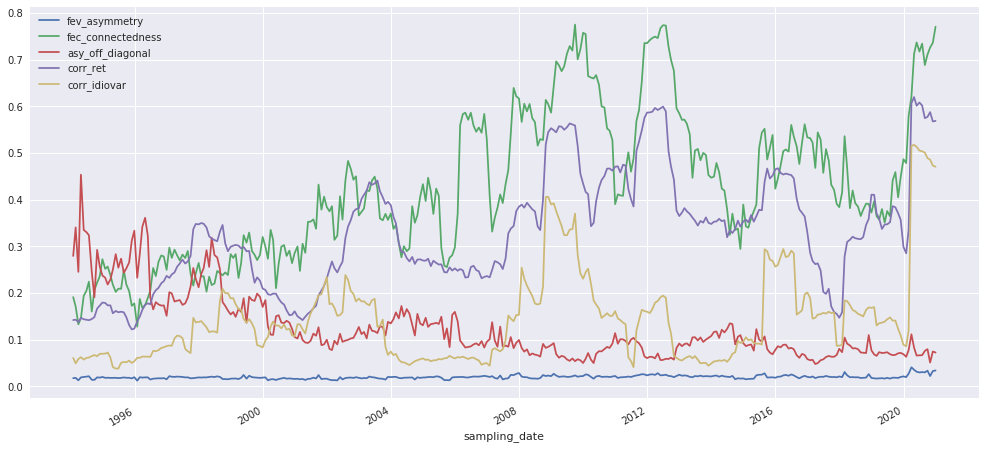

In [23]:
df_new_measures.plot()

### asd

In [39]:
reg_table = kf.RegressionTable()

# ew
index = 'ew'
reg_table = kf.RegressionTable()
reg = sm.OLS(endog=df_merged['ret_back_12M_ew'], exog=sm.add_constant(df_merged[['fev_asymmetry']]), missing='drop')\
                .fit(cov_type='HAC', cov_kwds={'maxlags': 1})
reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])
for h in [1, 3, 6, 9, 12]:
    y = df_merged['ret_forward_{}M_{}'.format(h, index)]
    X = sm.add_constant(df_merged[['fev_asymmetry']])#, 'ret_back_12M_{}'.format(index)]])
    reg = sm.OLS(endog=y, exog=X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': h})
    reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])
table = reg_table.copy()


# spy
index = 'spy'
reg_table = kf.RegressionTable()
reg = sm.OLS(endog=df_merged['ret_back_12M_spy'], exog=sm.add_constant(df_merged[['fev_asymmetry']]), missing='drop')\
                .fit(cov_type='HAC', cov_kwds={'maxlags': 1})
reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])
for h in [1, 3, 6, 9, 12]:
    y = df_merged['ret_forward_{}M_{}'.format(h, index)]
    X = sm.add_constant(df_merged[['fev_asymmetry']])#, 'ret_back_12M_{}'.format(index)]])
    reg = sm.OLS(endog=y, exog=X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': h})
    reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])
    
table = table.append(reg_table)\
             .change_row_labels({'const':'intercept',
                                 'fev_asymmetry':'Network asymmetry $a$',
                                 })\
             .drop_second_index()
table.columns = pd.MultiIndex.from_arrays([['same']+5*['horizon (months)'], ['period']+[1, 3, 6, 9, 12]])
table.export_to_latex('../reports/tables/index_returns_prediction.tex')
table

same horizon (months)                        \
                          period                1          3          6   
intercept              0.2246***           0.0017    -0.0428   -0.1117*   
                        (3.7598)         (0.1098)  (-1.3555)  (-1.8176)   
Network asymmetry $a$    -2.4746           0.3065   3.3636**  8.1689***   
                       (-0.8650)         (0.3856)   (2.1958)   (2.8622)   
R-squared                 0.0031           0.0007     0.0269     0.0665   
N                            324              323        321        318   
intercept               0.1106**           0.0038    -0.0372    -0.0911   
                        (2.0986)         (0.2387)  (-1.1375)  (-1.4836)   
Network asymmetry $a$    -0.1125           0.2546   3.2463**  7.4450***   
                       (-0.0439)         (0.3082)   (2.0347)   (2.6249)   
R-squared                 0.0000           0.0005     0.0252     0.0566   
N                            324              323        321        318   

                                              
                                9         12  
intercept                 -0.1565    -0.1466  
                        (-1.6336)  (-0.9801)  
Network asymmetry $a$  11.8072***   12.6711*  
                         (2.5896)   (1.7188)  
R-squared                  0.0753     0.0521  
N                             315        312  
intercept                 -0.1150    -0.0725  
                        (-1.2201)  (-0.5078)  
Network asymmetry $a$   10.1506**     9.4969  
                         (2.2987)   (1.3703)  
R-squared                  0.0574     0.0303  
N                             315        312

In [24]:
reg_table = kf.RegressionTable()

# contemporaneous regressions
reg = sm.OLS(endog=df_merged['ret_back_12M_ew'], exog=sm.add_constant(df_merged[['fev_asymmetry', 'var_back_12M_ew']]), missing='drop')\
                .fit(cov_type='HAC', cov_kwds={'maxlags': 1})
reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])
reg = sm.OLS(endog=df_merged['ret_back_12M_spy'], exog=sm.add_constant(df_merged[['fev_asymmetry', 'var_back_12M_spy']]), missing='drop')\
                .fit(cov_type='HAC', cov_kwds={'maxlags': 1})
reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])

# predictive regressions
for index in ['ew', 'spy']:
    for h in [1, 3, 6, 9, 12]:
        y = df_merged['ret_forward_{}M_{}'.format(h, index)]
        X = sm.add_constant(df_merged[['fev_asymmetry', 'var_back_12M_{}'.format(index)]])#, 'ret_back_12M_{}'.format(index)]])
        reg = sm.OLS(endog=y, exog=X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': h})
        reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])

# formatting
reg_table.change_row_labels({'const':'intercept',
                             'fev_asymmetry':'Network asymmetry$_{t-1Y:t}$',
                             'var_back_12M_ew':'Equally weighted variance$_{t-1Y:t}$',
                             'var_back_12M_spy':'SPY variance$_{t-1Y:t}$',
                             'ret_back_12M_ew':'Equally weighted return$_{t-1Y:t}$',
                             'ret_back_12M_spy':'SPY return$_{t-1Y:t}$'})\
         .change_column_labels({'(1)':'$R^{ew}_{t-1Y:t}$',
                                '(2)':'$R^{spy}_{t-1Y:t}$',
                                '(3)':'$R^{ew}_{t:t+1M}$',
                                '(4)':'$R^{ew}_{t:t+3M}$',
                                '(5)':'$R^{ew}_{t:t+6M}$',
                                '(6)':'$R^{ew}_{t:t+9M}$',
                                '(7)':'$R^{ew}_{t:t+12M}$',
                                '(8)':'$R^{spy}_{t:t+1M}$',
                                '(9)':'$R^{spy}_{t:t+3M}$',
                                '(10)':'$R^{spy}_{t:t+6M}$',
                                '(11)':'$R^{spy}_{t:t+9M}$',
                                '(12)':'$R^{spy}_{t:t+12M}$'})\
         .drop_second_index()
reg_table.columns = pd.MultiIndex.from_arrays([['contemporaneous']*2+['predictive']*10, reg_table.columns], names=['', 'horizon'])
    
reg_table.export_to_latex('../reports/tables/index_returns_prediction.tex')
reg_table

contemporaneous                     \
horizon                              $R^{ew}_{t-1Y:t}$ $R^{spy}_{t-1Y:t}$   
intercept                                    0.1977***             0.0696   
                                              (3.1038)           (1.3515)   
Network asymmetry$_{t-1Y:t}$                    1.3352           6.5544**   
                                              (0.4229)           (2.5545)   
Equally weighted variance$_{t-1Y:t}$        -1.3581***                      
                                             (-3.6910)                      
SPY variance$_{t-1Y:t}$                                        -2.5518***   
                                                                (-9.0243)   
N                                                  324                324   
R-squared                                       0.0837             0.3131   

                                            predictive                    \
horizon                              $R^{ew}_{t:t+1M}$ $R^{ew}_{t:t+3M}$   
intercept                                       0.0032           -0.0406   
                                              (0.2048)         (-1.2767)   
Network asymmetry$_{t-1Y:t}$                    0.0797           2.9699*   
                                              (0.0999)          (1.8454)   
Equally weighted variance$_{t-1Y:t}$            0.0852            0.1593   
                                              (1.0697)          (0.7970)   
SPY variance$_{t-1Y:t}$                                                    
                                                                           
N                                                  323               321   
R-squared                                       0.0056            0.0325   

                                                                          \
horizon                              $R^{ew}_{t:t+6M}$ $R^{ew}_{t:t+9M}$   
intercept                                     -0.1099*           -0.1575   
                                             (-1.7584)         (-1.6333)   
Network asymmetry$_{t-1Y:t}$                  7.5729**         11.3474**   
                                              (2.4605)          (2.3786)   
Equally weighted variance$_{t-1Y:t}$            0.2882            0.2970   
                                              (0.8688)          (0.6277)   
SPY variance$_{t-1Y:t}$                                                    
                                                                           
N                                                  318               315   
R-squared                                       0.0749            0.0806   

                                                                            \
horizon                              $R^{ew}_{t:t+12M}$ $R^{spy}_{t:t+1M}$   
intercept                                       -0.1480             0.0049   
                                              (-0.9881)           (0.3055)   
Network asymmetry$_{t-1Y:t}$                    12.3072             0.0657   
                                               (1.6107)           (0.0797)   
Equally weighted variance$_{t-1Y:t}$             0.2526                      
                                               (0.4450)                      
SPY variance$_{t-1Y:t}$                                             0.0759   
                                                                  (0.8451)   
N                                                   312                323   
R-squared                                        0.0549             0.0046   

                                                                            \
horizon                              $R^{spy}_{t:t+3M}$ $R^{spy}_{t:t+6M}$   
intercept                                       -0.0356            -0.0900   
                                              (-1.0869)          (-1.4495)   
Network asymmetry$_{t-1Y:t}$           

In [85]:
reg_table = kf.RegressionTable()

# contemporaneous regressions
reg = sm.OLS(endog=df_merged['var_back_12M_ew'], exog=sm.add_constant(df_merged[['fev_avg_connectedness_normalised', 'ret_back_12M_ew']]), missing='drop')\
                .fit(cov_type='HAC', cov_kwds={'maxlags': 1})
reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])
reg = sm.OLS(endog=df_merged['var_back_12M_spy'], exog=sm.add_constant(df_merged[['fev_avg_connectedness_normalised', 'ret_back_12M_spy']]), missing='drop')\
                .fit(cov_type='HAC', cov_kwds={'maxlags': 1})
reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])

# predictive regressions
for index in ['ew', 'spy']:
    for h in [1, 3, 6, 9, 12]:
        y = df_merged['var_forward_{}M_{}'.format(h, index)]
        X = sm.add_constant(df_merged[['fev_avg_connectedness_normalised', 'var_back_12M_{}'.format(index), 'ret_back_12M_{}'.format(index)]])
        reg = sm.OLS(endog=y, exog=X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': h})
        reg_table = reg_table.join_regression(reg, add_outputs=['R-squared', 'N'])

# formatting
reg_table.change_row_labels({'const':'intercept',
                             'fev_asymmetry':'Network asymmetry$_{t-1Y:t}$',
                             'var_back_12M_ew':'Equally weighted variance$_{t-1Y:t}$',
                             'var_back_12M_spy':'SPY variance$_{t-1Y:t}$',
                             'ret_back_12M_ew':'Equally weighted return$_{t-1Y:t}$',
                             'ret_back_12M_spy':'SPY return$_{t-1Y:t}$'})\
         .change_column_labels({'(1)':'$R^{ew}_{t-1Y:t}$',
                                '(2)':'$R^{spy}_{t-1Y:t}$',
                                '(3)':'$R^{ew}_{t:t+1M}$',
                                '(4)':'$R^{ew}_{t:t+3M}$',
                                '(5)':'$R^{ew}_{t:t+6M}$',
                                '(6)':'$R^{ew}_{t:t+9M}$',
                                '(7)':'$R^{ew}_{t:t+12M}$',
                                '(8)':'$R^{spy}_{t:t+1M}$',
                                '(9)':'$R^{spy}_{t:t+3M}$',
                                '(10)':'$R^{spy}_{t:t+6M}$',
                                '(11)':'$R^{spy}_{t:t+9M}$',
                                '(12)':'$R^{spy}_{t:t+12M}$'})\
         .drop_second_index()
reg_table.columns = pd.MultiIndex.from_arrays([['contemporaneous']*2+['predictive']*10, reg_table.columns], names=['', 'horizon'])
    
reg_table.export_to_latex('../reports/tables/index_returns_prediction.tex')
reg_table

contemporaneous                     \
horizon                              $R^{ew}_{t-1Y:t}$ $R^{spy}_{t-1Y:t}$   
intercept                                      -0.0012           0.0130**   
                                             (-0.1694)           (2.0470)   
fev_avg_connectedness_normalised             0.1016***          0.0791***   
                                              (5.1913)           (4.5538)   
Equally weighted return$_{t-1Y:t}$            -0.0367*                      
                                             (-1.8618)                      
SPY return$_{t-1Y:t}$                                          -0.1024***   
                                                                (-4.9976)   
Equally weighted variance$_{t-1Y:t}$                                        
                                                                            
SPY variance$_{t-1Y:t}$                                                     
                                                                            
N                                                  324                324   
R-squared                                       0.2566             0.3965   

                                            predictive                    \
horizon                              $R^{ew}_{t:t+1M}$ $R^{ew}_{t:t+3M}$   
intercept                                    0.0374***         0.0332***   
                                              (3.5788)          (2.8304)   
fev_avg_connectedness_normalised                0.0060            0.0083   
                                              (0.1952)          (0.2857)   
Equally weighted return$_{t-1Y:t}$           -0.0781**           -0.0426   
                                             (-2.1634)         (-1.0816)   
SPY return$_{t-1Y:t}$                                                      
                                                                           
Equally weighted variance$_{t-1Y:t}$           0.3162*            0.2613   
                                              (1.8863)          (1.4650)   
SPY variance$_{t-1Y:t}$                                                    
                                                                           
N                                                  323               321   
R-squared                                       0.0723            0.0513   

                                                                          \
horizon                              $R^{ew}_{t:t+6M}$ $R^{ew}_{t:t+9M}$   
intercept                                    0.0335***         0.0333***   
                                              (2.8393)          (2.5983)   
fev_avg_connectedness_normalised                0.0100            0.0140   
                                              (0.3075)          (0.3356)   
Equally weighted return$_{t-1Y:t}$             -0.0326           -0.0290   
                                             (-0.7935)         (-0.7340)   
SPY return$_{t-1Y:t}$                                                      
                                                                           
Equally weighted variance$_{t-1Y:t}$            0.2083            0.1665   
                                              (1.1130)          (0.8515)   
SPY variance$_{t-1Y:t}$                                                    
                                                                           
N                                                  318               315   
R-squared                                       0.0444            0.0411   

                                                                            \
horizon                              $R^{ew}_{t:t+12M}$ $R^{spy}_{t:t+1M}$   
intercept                                      0.0330**          0.0381***   
                                               (2.2689)           (3.6192)   
fev_avg_connectedness_normalised                 0.0155     

In [143]:
# load daily data
daily_data = pd.DataFrame([])
for year in range(1994,2020):
    for month in range(1, 13):
        daily_data = daily_data.append(pd.read_csv('../data/processed/monthly/{}/{}/df_forward.csv'.format(year, month)))

In [145]:
daily_data.head(3)

date  permno ticker          mcap    var  noisevar  retadj
0  1994-02-01   10104   ORCL  9208420.7500 0.0001    0.0000 -0.0117
1  1994-02-01   10107   MSFT 24175500.0000 0.0000    0.0000  0.0000
2  1994-02-01   10145    ALD 11298740.7500 0.0000    0.0000  0.0143

In [148]:
df_aggregate.shape

(104, 19)

In [122]:
estimation_columns = ['fev_avg_connectedness', 'fev_avg_connectedness_normalised',
                      'fu_avg_connectedness', 'fu_avg_connectedness_normalised',
                      'fev_asymmetry', 'fev_asymmetry_normalised',
                      'fu_asymmetry', 'fu_asymmetry_normalised']
df_aggregate = estimation_stats[estimation_columns]
horizons = [1, 2, 3, 6, 9, 12, 18, 24, 36, 48, 60]
for h in horizons:
    forward_return = spy['ret']\
                         .rolling(h).apply(lambda x: (1+x).prod()-1)\
                         .shift(-h)\
                         .rename('spy_forward{}'.format(h))
    df_aggregate = df_aggregate.join(forward_return, how='left')
df_aggregate = kf.FinancialDataFrame(df_aggregate)

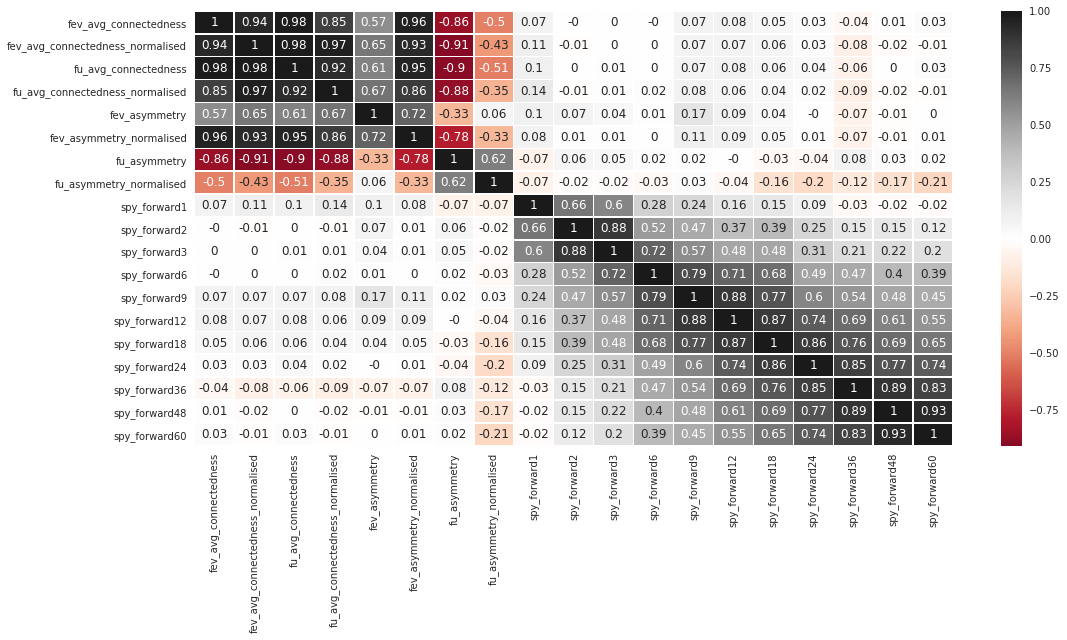

In [123]:
df_aggregate.plot_corr()
plt.show()

In [134]:
reg_table = kf.RegressionTable()
for h in horizons:
    reg = df_aggregate.fit_linear_regression(endog='spy_forward{}'.format(h), exog=estimation_columns)
    reg_table = reg_table.join_regression(reg)
reg_table

(1)        (2)        (3)  \
const                            coeff     -0.1535    -0.0360    -0.1009   
                                 t-stat  (-1.2196)  (-0.1929)  (-0.4862)   
fev_avg_connectedness            coeff     -0.0233    -0.0403    -0.0442   
                                 t-stat  (-0.8616)  (-1.0050)  (-0.9913)   
fev_avg_connectedness_normalised coeff      0.0065    -0.0046     0.1352   
                                 t-stat   (0.0568)  (-0.0269)   (0.7132)   
fu_avg_connectedness             coeff      0.0047     0.0095     0.0083   
                                 t-stat   (0.7669)   (1.0572)   (0.8234)   
fu_avg_connectedness_normalised  coeff      0.1661    -0.0065     0.0263   
                                 t-stat   (0.8931)  (-0.0236)   (0.0857)   
fev_asymmetry                    coeff     -1.7283    -1.3662   -3.7633*   
                                 t-stat  (-1.2802)  (-0.6829)  (-1.6903)   
fev_asymmetry_normalised         coeff      0.6426     1.0258     1.1740   
                                 t-stat   (0.6413)   (0.6908)   (0.7103)   
fu_asymmetry                     coeff     0.4769*     0.5074   1.0803**   
                                 t-stat   (1.6812)   (1.2072)   (2.3096)   
fu_asymmetry_normalised          coeff     -0.2020    -0.2344    -0.3490   
                                 t-stat  (-1.3192)  (-1.0330)  (-1.3819)   

                                               (4)        (5)        (6)  \
const                            coeff     -0.3354    -0.2297    -0.1819   
                                 t-stat  (-1.1170)  (-0.6721)  (-0.4434)   
fev_avg_connectedness            coeff     -0.0460    -0.0535     0.0045   
                                 t-stat  (-0.7133)  (-0.7283)   (0.0512)   
fev_avg_connectedness_normalised coeff     -0.0440     0.0999     0.4903   
                                 t-stat  (-0.1604)   (0.3198)   (1.3079)   
fu_avg_connectedness             coeff      0.0082     0.0080    -0.0043   
                                 t-stat   (0.5682)   (0.4875)  (-0.2186)   
fu_avg_connectedness_normalised  coeff      0.3959     0.1532     0.0254   
                                 t-stat   (0.8924)   (0.3034)   (0.0418)   
fev_asymmetry                    coeff     -4.3053    -3.4246    -5.7248   
                                 t-stat  (-1.3368)  (-0.9342)  (-1.3007)   
fev_asymmetry_normalised         coeff      2.1422     2.4256    -0.2440   
                                 t-stat   (0.8960)   (0.8914)  (-0.0747)   
fu_asymmetry                     coeff      0.9735    1.2758*   2.2794**   
                                 t-stat   (1.4387)   (1.6564)   (2.4650)   
fu_asymmetry_normalised          coeff     -0.4519    -0.4440    -0.6735   
                                 t-stat  (-1.2372)  (-1.0679)  (-1.3491)   

                                                (7)         (8)        (9)  \
const                            coeff       0.3163      0.4871     0.0669   
                                 t-stat    (0.6674)    (0.9523)   (0.1027)   
fev_avg_connectedness            coeff      -0.0989     -0.0899     0.0521   
                                 t-stat   (-0.9713)   (-0.8183)   (0.3725)   
fev_avg_connectedness_normalised coeff      0.8381*     0.7967*     0.6530   
                                 t-stat    (1.9357)    (1.7048)   (1.0971)   
fu_avg_connectedness             coeff       0.0004      0.0028    -0.0186   
                                 t-stat    (0.0178)    (0.1122)  (-0.5907)   
fu_avg_connectedness_normalised  coeff      -0.5860     -0.7435    -0.1206   
                                 t-stat   (-0.8368)   (-0.9837)  (-0.1253)   
fev_asymmetry                    coeff      -7.9939     -5.9431    -4.3599   
                                 t-stat   (-1.5724)   (-1.0831)  (-0.6239)   
fev_asymmetry_normalised         coeff       3.2279      1.7137    -1.7327   
                                 t-stat    (0.8553)    (0.4207)  

In [137]:
reg_table = kf.RegressionTable()
for h in horizons:
    reg = df_aggregate.fit_linear_regression(endog='spy_forward{}'.format(h), exog='fev_avg_connectedness_normalised')
    reg_table = reg_table.join_regression(reg)
reg_table

(1)        (2)       (3)  \
const                            coeff     -0.0002     0.0043    0.0050   
                                 t-stat  (-0.0605)   (0.8267)  (0.8640)   
fev_avg_connectedness_normalised coeff      0.0088    -0.0012    0.0004   
                                 t-stat   (1.1000)  (-0.0995)  (0.0281)   

                                              (4)        (5)       (6)  \
const                            coeff     0.0041    -0.0013    0.0008   
                                 t-stat  (0.4930)  (-0.1359)  (0.0729)   
fev_avg_connectedness_normalised coeff     0.0003     0.0161    0.0187   
                                 t-stat  (0.0172)   (0.7461)  (0.7198)   

                                              (7)       (8)        (9)  \
const                            coeff     0.0017    0.0101    0.0312*   
                                 t-stat  (0.1277)  (0.6902)   (1.6956)   
fev_avg_connectedness_normalised coeff     0.0174    0.0106    -0.0323   
                                 t-stat  (0.5704)  (0.3228)  (-0.7794)   

                                              (10)       (11)  
const                            coeff      0.0268     0.0268  
                                 t-stat   (1.3120)   (1.1392)  
fev_avg_connectedness_normalised coeff     -0.0091    -0.0053  
                                 t-stat  (-0.1977)  (-0.1006)

In [ ]:
_.iloc[:,1].set_obstype('return').summarise_performance

In [30]:
df_aggregate.corr().iloc[1:,0]

NameError: name 'df_aggregate' is not defined

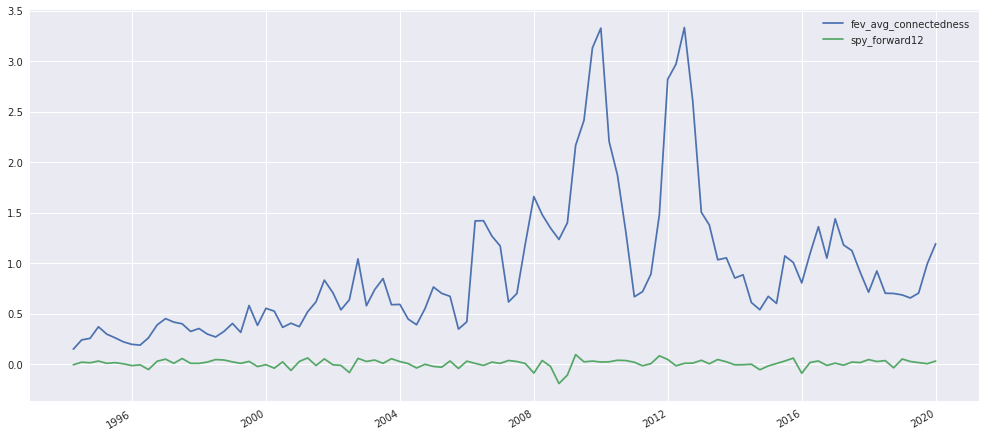

In [52]:
df_aggregate.plot()

In [14]:
#summary_stats = pd.read_csv('../data/estimated/summary_stats.csv').set_index(['sampling_year', 'permno'])
# factor_models = pd.read_csv('../data/estimated/factor_models.csv').set_index(['sampling_year', 'permno'])
network_data = pd.read_csv('../data/estimated/network_data.csv').set_index(['sampling_date', 'permno'])
estimation_statistics = pd.read_csv('../data/estimated/estimation_statistics.csv', index_col=0)
pd.read_csv('../data/estimated/factor_exposures.csv')

In [16]:
network_data = pd.read_csv('../data/estimated/network_data_2.csv').set_index(['sampling_year', 'permno'])
estimation_statistics = pd.read_csv('../data/estimated/estimation_statistics_2.csv', index_col=0)

FileNotFoundError: [Errno 2] File ../data/estimated/network_data_2.csv does not exist: '../data/estimated/network_data_2.csv'

In [26]:
df = summary_stats.merge(factor_models, how='outer', left_index=True, right_on=['sampling_year', 'permno'])\
                  .merge(network_data, how='outer', left_index=True, right_on=['sampling_year', 'permno'])
df = kf.FinancialDataFrame(df)

In [27]:
df.fit_panel_regression(endog='Total return (t+1)', exog=['ret', 'fev_all'], fixed_effects='entity')

/home/rubelrennfix/.virtualenvs/euraculus/lib/python3.6/site-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:     Total return (t+1)   R-squared:                        0.0010
Estimator:                   PanelOLS   R-squared (Between):             -0.2860
No. Observations:                2500   R-squared (Within):               0.0010
Date:                Thu, Nov 05 2020   R-squared (Overall):             -0.1113
Time:                        14:51:50   Log-likelihood                   -336.33
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      1.2879
Entities:                          25   P-value                           0.2760
Avg Obs:                      100.000   Distribution:                  F(2,2473)
Min Obs:                      100.000                                           
Max Obs:                      100.000   F-statistic (robust):             1.0400
                                        P-value                           0.3536
Time periods:                     274   Distribution:                  F(2,2473)
Avg Obs:                       9.1241                                           
Min Obs:                       1.0000                                           
Max Obs:                       25.000                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
ret           -0.0019     0.0194    -0.0994     0.9209     -0.0399      0.0360
fev_all       -0.2042     0.1524    -1.3403     0.1803     -0.5030      0.0945
==============================================================================

F-test for Poolability: 44.772
P-value: 0.0000
Distribution: F(24,2473)

Included effects: Entity
PanelEffectsResults, id: 0x7f3aab45aba8

In [13]:
def mean_portfolio_stat(df, sort_col, stat_col, n_port=5):
    labels = ['Low'] + list(np.arange(2,n_port).astype(str)) + ['High']
    pfs = df[sort_col].dropna().groupby('sampling_year').apply(lambda x: pd.qcut(x, q=n_port, labels=labels)).rename('sort')
    df_ = df[stat_col].to_frame().merge(pfs, how='left', left_index=True, right_on=['sampling_year', 'permno'])
    pf_rets = df_.groupby(['sampling_year', 'sort'])[stat_col].mean().unstack()
    return pf_rets

KeyError: 'beta'

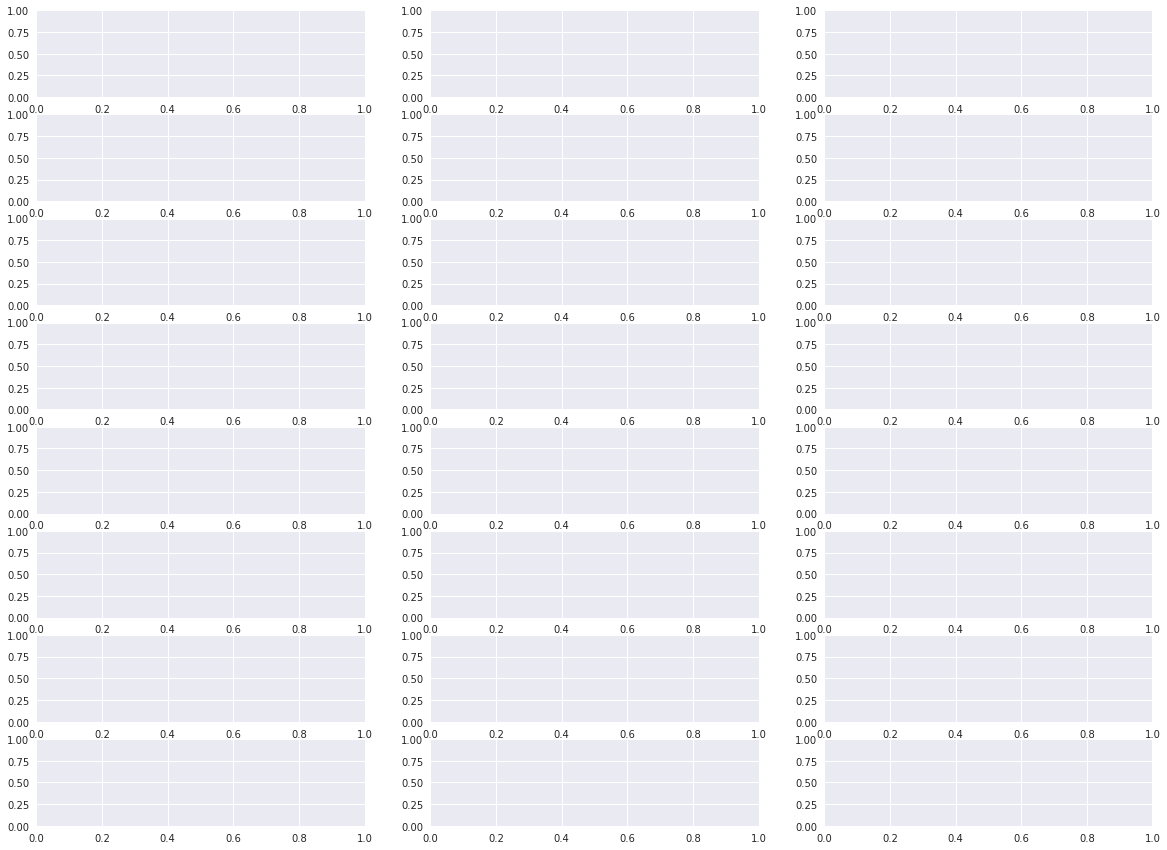

In [24]:
outcomes = ['Total return (t)', 'Total return (t+1)', 'beta', 'beta_t+1', 'alpha', 'alpha_t+1', 'Volatility p.a. (t)', 'Volatility p.a. (t+1)']
rankings = ['beta', 'fev_others', 'in_connectedness']#, 'VAR_intercept', 'in_lvl']

fig, axes = plt.subplots(len(outcomes), len(rankings), figsize=[20, 15])

for i, outcome in enumerate(outcomes):
    for j, ranking in enumerate(rankings):
        axes[i,j].plot(mean_portfolio_stat(df, ranking, outcome, 5).mean(), marker='o', markersize=10)
        axes[i,j].set_title('{} of portfolios sorted on {}'.format(outcome, ranking))

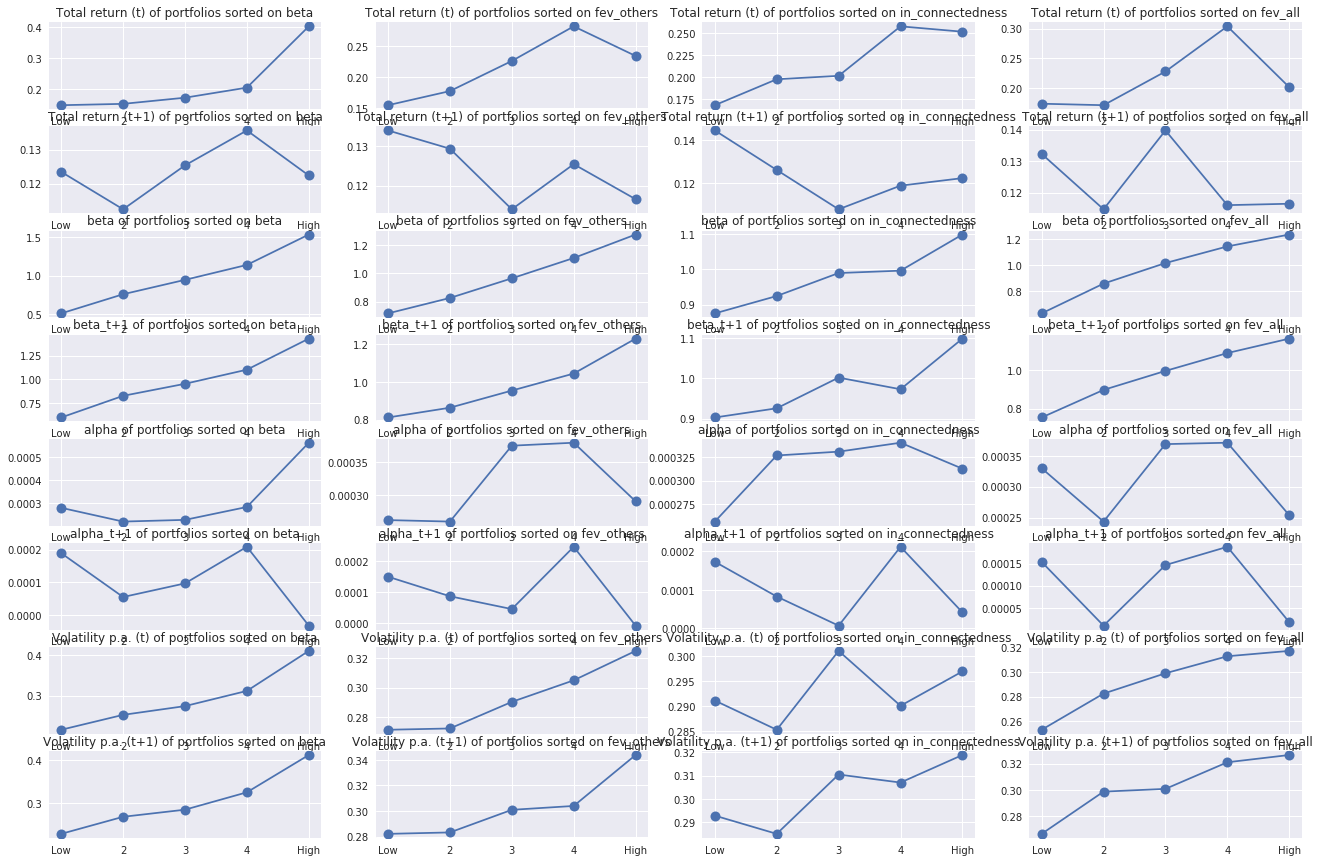

In [325]:
outcomes = ['Total return (t)', 'Total return (t+1)', 'beta', 'beta_t+1', 'alpha', 'alpha_t+1', 'Volatility p.a. (t)', 'Volatility p.a. (t+1)']
rankings = ['beta', 'fev_others', 'in_connectedness', 'fev_all']#, 'VAR_intercept', 'in_lvl']

fig, axes = plt.subplots(len(outcomes), len(rankings), figsize=[20, 15])

for i, outcome in enumerate(outcomes):
    for j, ranking in enumerate(rankings):
        axes[i,j].plot(mean_portfolio_stat(df, ranking, outcome, 5).mean(), marker='o', markersize=10)
        axes[i,j].set_title('{} of portfolios sorted on {}'.format(outcome, ranking))

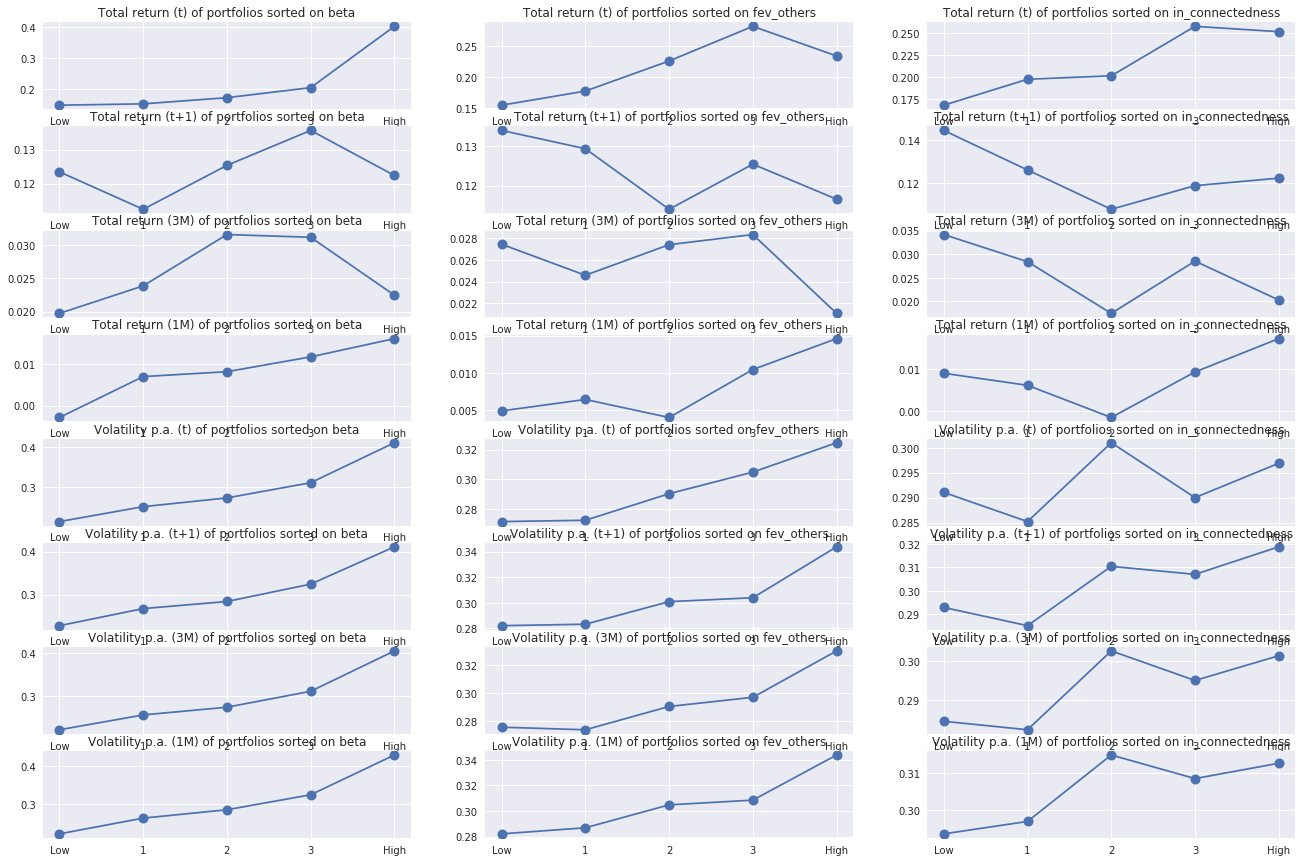

In [320]:
outcomes = ['Total return (t)', 'Total return (t+1)', 'Total return (3M)', 'Total return (1M)', 'Volatility p.a. (t)', 'Volatility p.a. (t+1)', 'Volatility p.a. (3M)', 'Volatility p.a. (1M)']
rankings = ['beta', 'fev_others', 'in_connectedness']#, 'VAR_intercept', 'in_lvl']

fig, axes = plt.subplots(len(outcomes), len(rankings), figsize=[20, 15])

for i, outcome in enumerate(outcomes):
    for j, ranking in enumerate(rankings):
        axes[i,j].plot(mean_portfolio_return(df, ranking, outcome, 5).mean(), marker='o', markersize=10)
        axes[i,j].set_title('{} of portfolios sorted on {}'.format(outcome, ranking))

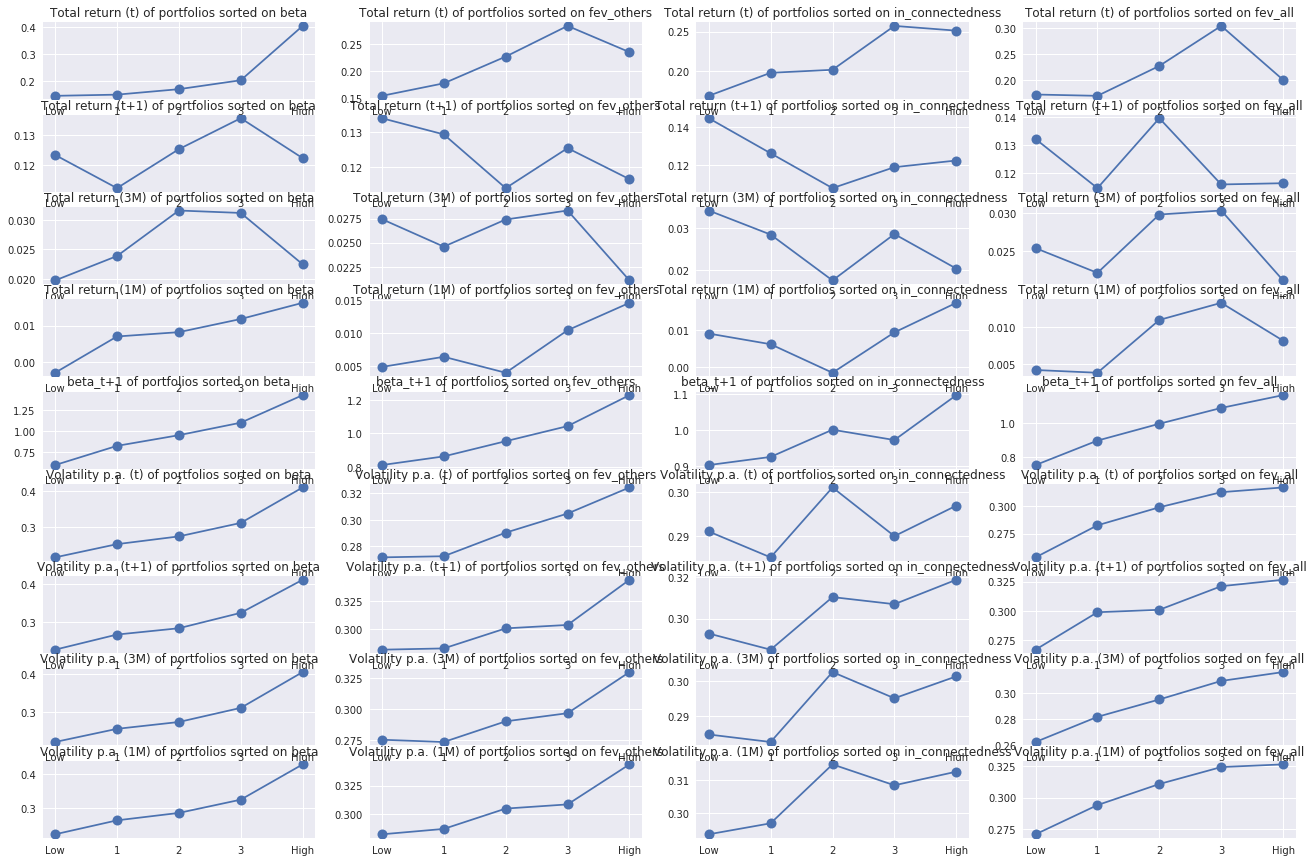

In [324]:
outcomes = ['Total return (t)', 'Total return (t+1)', 'Total return (3M)', 'Total return (1M)', 'beta_t+1', 'Volatility p.a. (t)', 'Volatility p.a. (t+1)', 'Volatility p.a. (3M)', 'Volatility p.a. (1M)']
rankings = ['beta', 'fev_others', 'in_connectedness', 'fev_all']#, 'VAR_intercept', 'in_lvl']

fig, axes = plt.subplots(len(outcomes), len(rankings), figsize=[20, 15])

for i, outcome in enumerate(outcomes):
    for j, ranking in enumerate(rankings):
        axes[i,j].plot(mean_portfolio_return(df, ranking, outcome, 5).mean(), marker='o', markersize=10)
        axes[i,j].set_title('{} of portfolios sorted on {}'.format(outcome, ranking))

In [42]:
df.columns

Index(['Return p.a. (arithmetic) (t)', 'Return p.a. (geometric) (t)',
       'Volatility p.a. (t)', 'Sharpe ratio (t)', 't-stat (t)',
       'Total return (t)', 'Positive returns % (t)', 'VaR 95% (historic) (t)',
       'VaR 95% (parametric) (t)', 'Expected shortfall 95% (t)',
       'Downside volatility (t)', 'Maximum drawdown (t)',
       'Return p.a. (arithmetic) (t+1)', 'Return p.a. (geometric) (t+1)',
       'Volatility p.a. (t+1)', 'Sharpe ratio (t+1)', 't-stat (t+1)',
       'Total return (t+1)', 'Positive returns % (t+1)',
       'VaR 95% (historic) (t+1)', 'VaR 95% (parametric) (t+1)',
       'Expected shortfall 95% (t+1)', 'Downside volatility (t+1)',
       'Maximum drawdown (t+1)', 'alpha', 'beta', 'alpha_t+1', 'beta_t+1',
       'VAR_intercept', 'mean_abs_VAR_in', 'mean_abs_VAR_out',
       'residual_variance', 'mean_resid_corr', 'in_connectedness',
       'out_connectedness', 'fev_others', 'fev_all', 'eigenvector_centrality',
       'closeness_centrality'],
      dtype='o

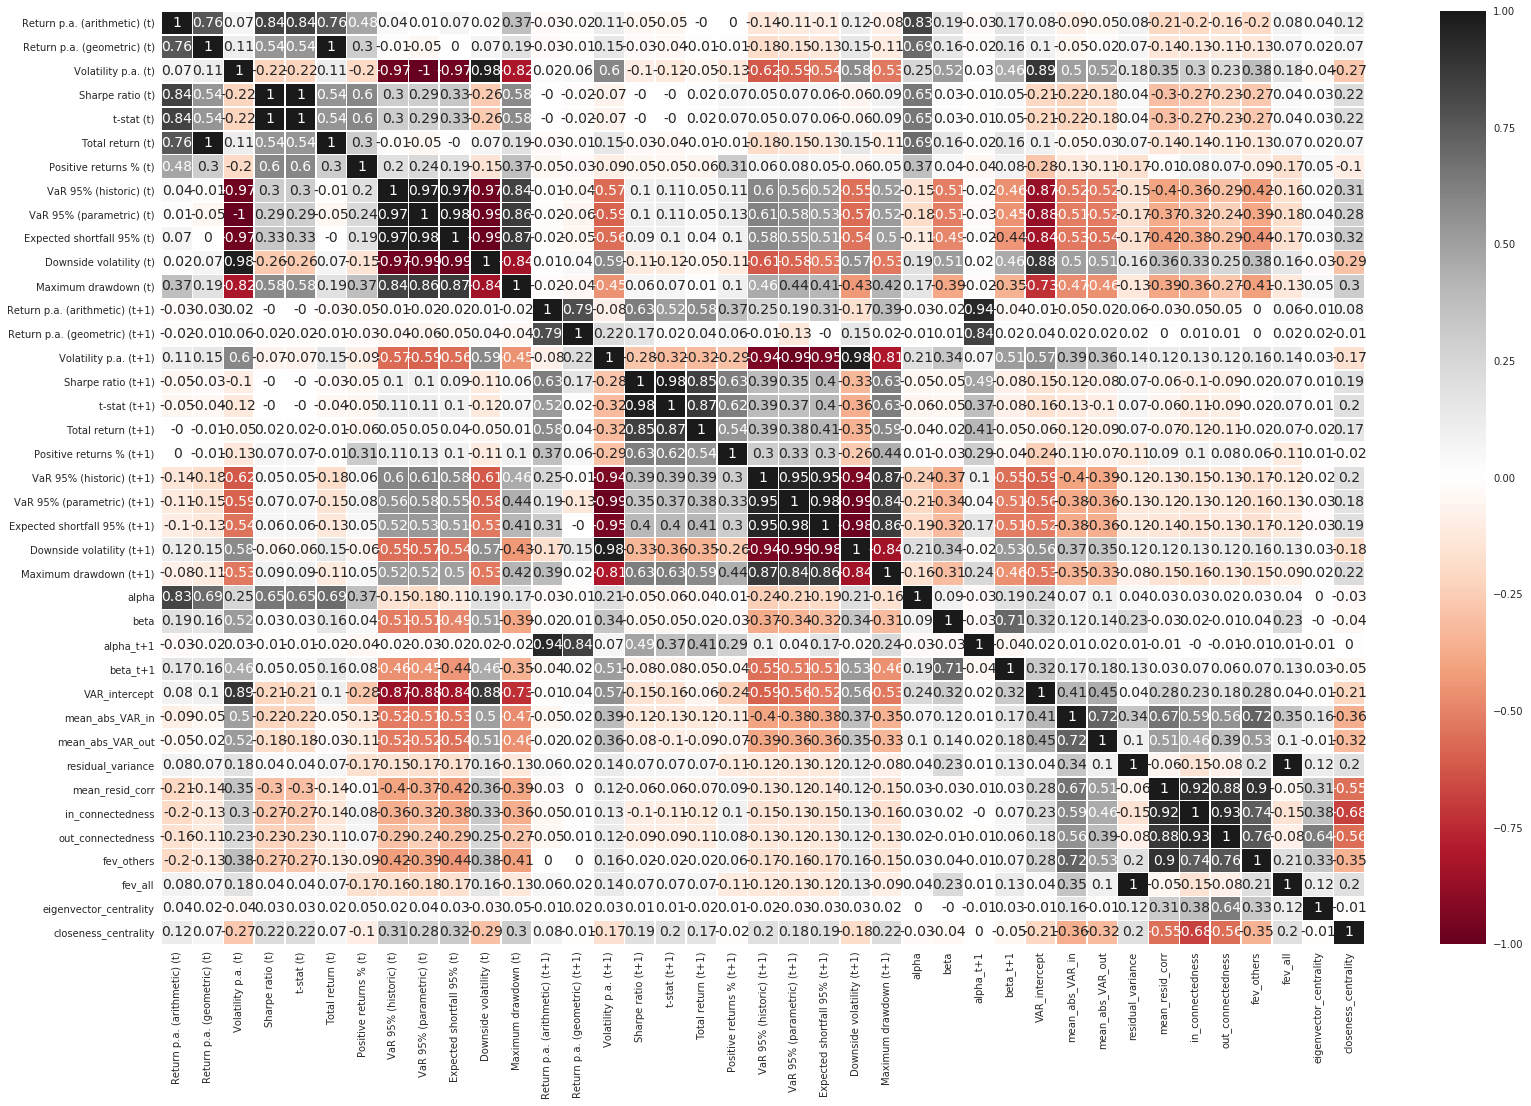

In [224]:
_ = df.plot_corr(figsize=[24,16])

## Load & prepare data
#### Previously saved

In [7]:
df_crsp_desc = pd.read_pickle('../data/raw/df_crsp_desc.pkl')

In [8]:
df_ff_raw = pd.read_pickle('../data/raw/df_ff_raw.pkl')
df_ff_raw['date'] = pd.to_datetime(df_ff_raw['date'], yearfirst=True)
df_ff_raw = df_ff_raw.set_index('date')

In [9]:
df_estimates = pd.read_pickle('../data/processed/df_estimates.pkl')
df_analysis = pd.read_pickle('../data/processed/df_analysis.pkl')

In [10]:
df_indices = pd.read_pickle('../data/processed/df_indices.pkl')

### Merge data & Explore

In [11]:
df_merged = kf.FinancialDataFrame(df_estimates.merge(df_analysis, how='outer', left_index=True, right_index=True, suffixes=('_est','_ana')))

In [12]:
df_merged['in_lagged'] = df_merged['in'].groupby(df_merged.index.get_level_values(1)).shift(1)
df_merged['in_pct'] = df_merged['in']/df_merged['vola_est']
df_merged['sqrt_in'] = np.sqrt(df_merged['in'])

In [13]:
df_merged.describe()

in       out  capm_alpha_est  capm_mktrf_est  ff3f_alpha_est  \
count 1900.0000 1900.0000       1900.0000       1900.0000       1900.0000   
mean     0.0050    0.0050          0.0003          0.9737          0.0003   
std      0.0068    0.0053          0.0009          0.4127          0.0009   
min      0.0000    0.0001         -0.0047         -0.1588         -0.0033   
25%      0.0012    0.0014         -0.0002          0.7197         -0.0002   
50%      0.0027    0.0029          0.0003          0.9458          0.0003   
75%      0.0058    0.0065          0.0008          1.1952          0.0007   
max      0.0560    0.0253          0.0074          3.0914          0.0097   

       ff3f_mktrf_est  ff3f_smb_est  ff3f_hml_est  c4f_alpha_est  \
count       1900.0000     1900.0000     1900.0000      1900.0000   
mean           1.0048       -0.1737       -0.0036         0.0003   
std            0.3358        0.3094        0.7337         0.0009   
min           -0.0147       -2.4796       -2.6741        -0.0034   
25%            0.7749       -0.3604       -0.3927        -0.0002   
50%            0.9955       -0.1836       -0.0626         0.0003   
75%            1.2156       -0.0055        0.3468         0.0007   
max            2.3580        1.2087        4.5024         0.0096   

       c4f_mktrf_est  ...  ret3M_ana  ret12M_ana   ret_ana  vola1M_ana  \
count      1900.0000  ...  1896.0000   1896.0000 1896.0000   1896.0000   
mean          1.0076  ...     0.0110      0.0834    0.0834      0.0182   
std           0.2953  ...     0.1338      0.2875    0.2875      0.0123   
min           0.0513  ...    -0.6989     -1.0000   -1.0000      0.0011   
25%           0.8073  ...    -0.0588     -0.0701   -0.0701      0.0111   
50%           1.0033  ...     0.0133      0.0893    0.0893      0.0151   
75%           1.1941  ...     0.0885      0.2428    0.2428      0.0214   
max           2.3399  ...     0.8183      1.6232    1.6232      0.1503   

       vola3M_ana  vola12M_ana  vola_ana  in_lagged    in_pct   sqrt_in  
count   1896.0000    1896.0000 1896.0000  1881.0000 1900.0000 1900.0000  
mean       0.0175       0.0181    0.0181     0.0051    0.2235    0.0605  
std        0.0115       0.0123    0.0123     0.0069    0.1904    0.0371  
min        0.0015       0.0015    0.0015     0.0000    0.0069    0.0063  
25%        0.0112       0.0117    0.0117     0.0012    0.0862    0.0345  
50%        0.0147       0.0150    0.0150     0.0027    0.1692    0.0515  
75%        0.0199       0.0202    0.0202     0.0058    0.2929    0.0763  
max        0.1503       0.1868    0.1868     0.0560    1.2670    0.2366  

[8 rows x 43 columns]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


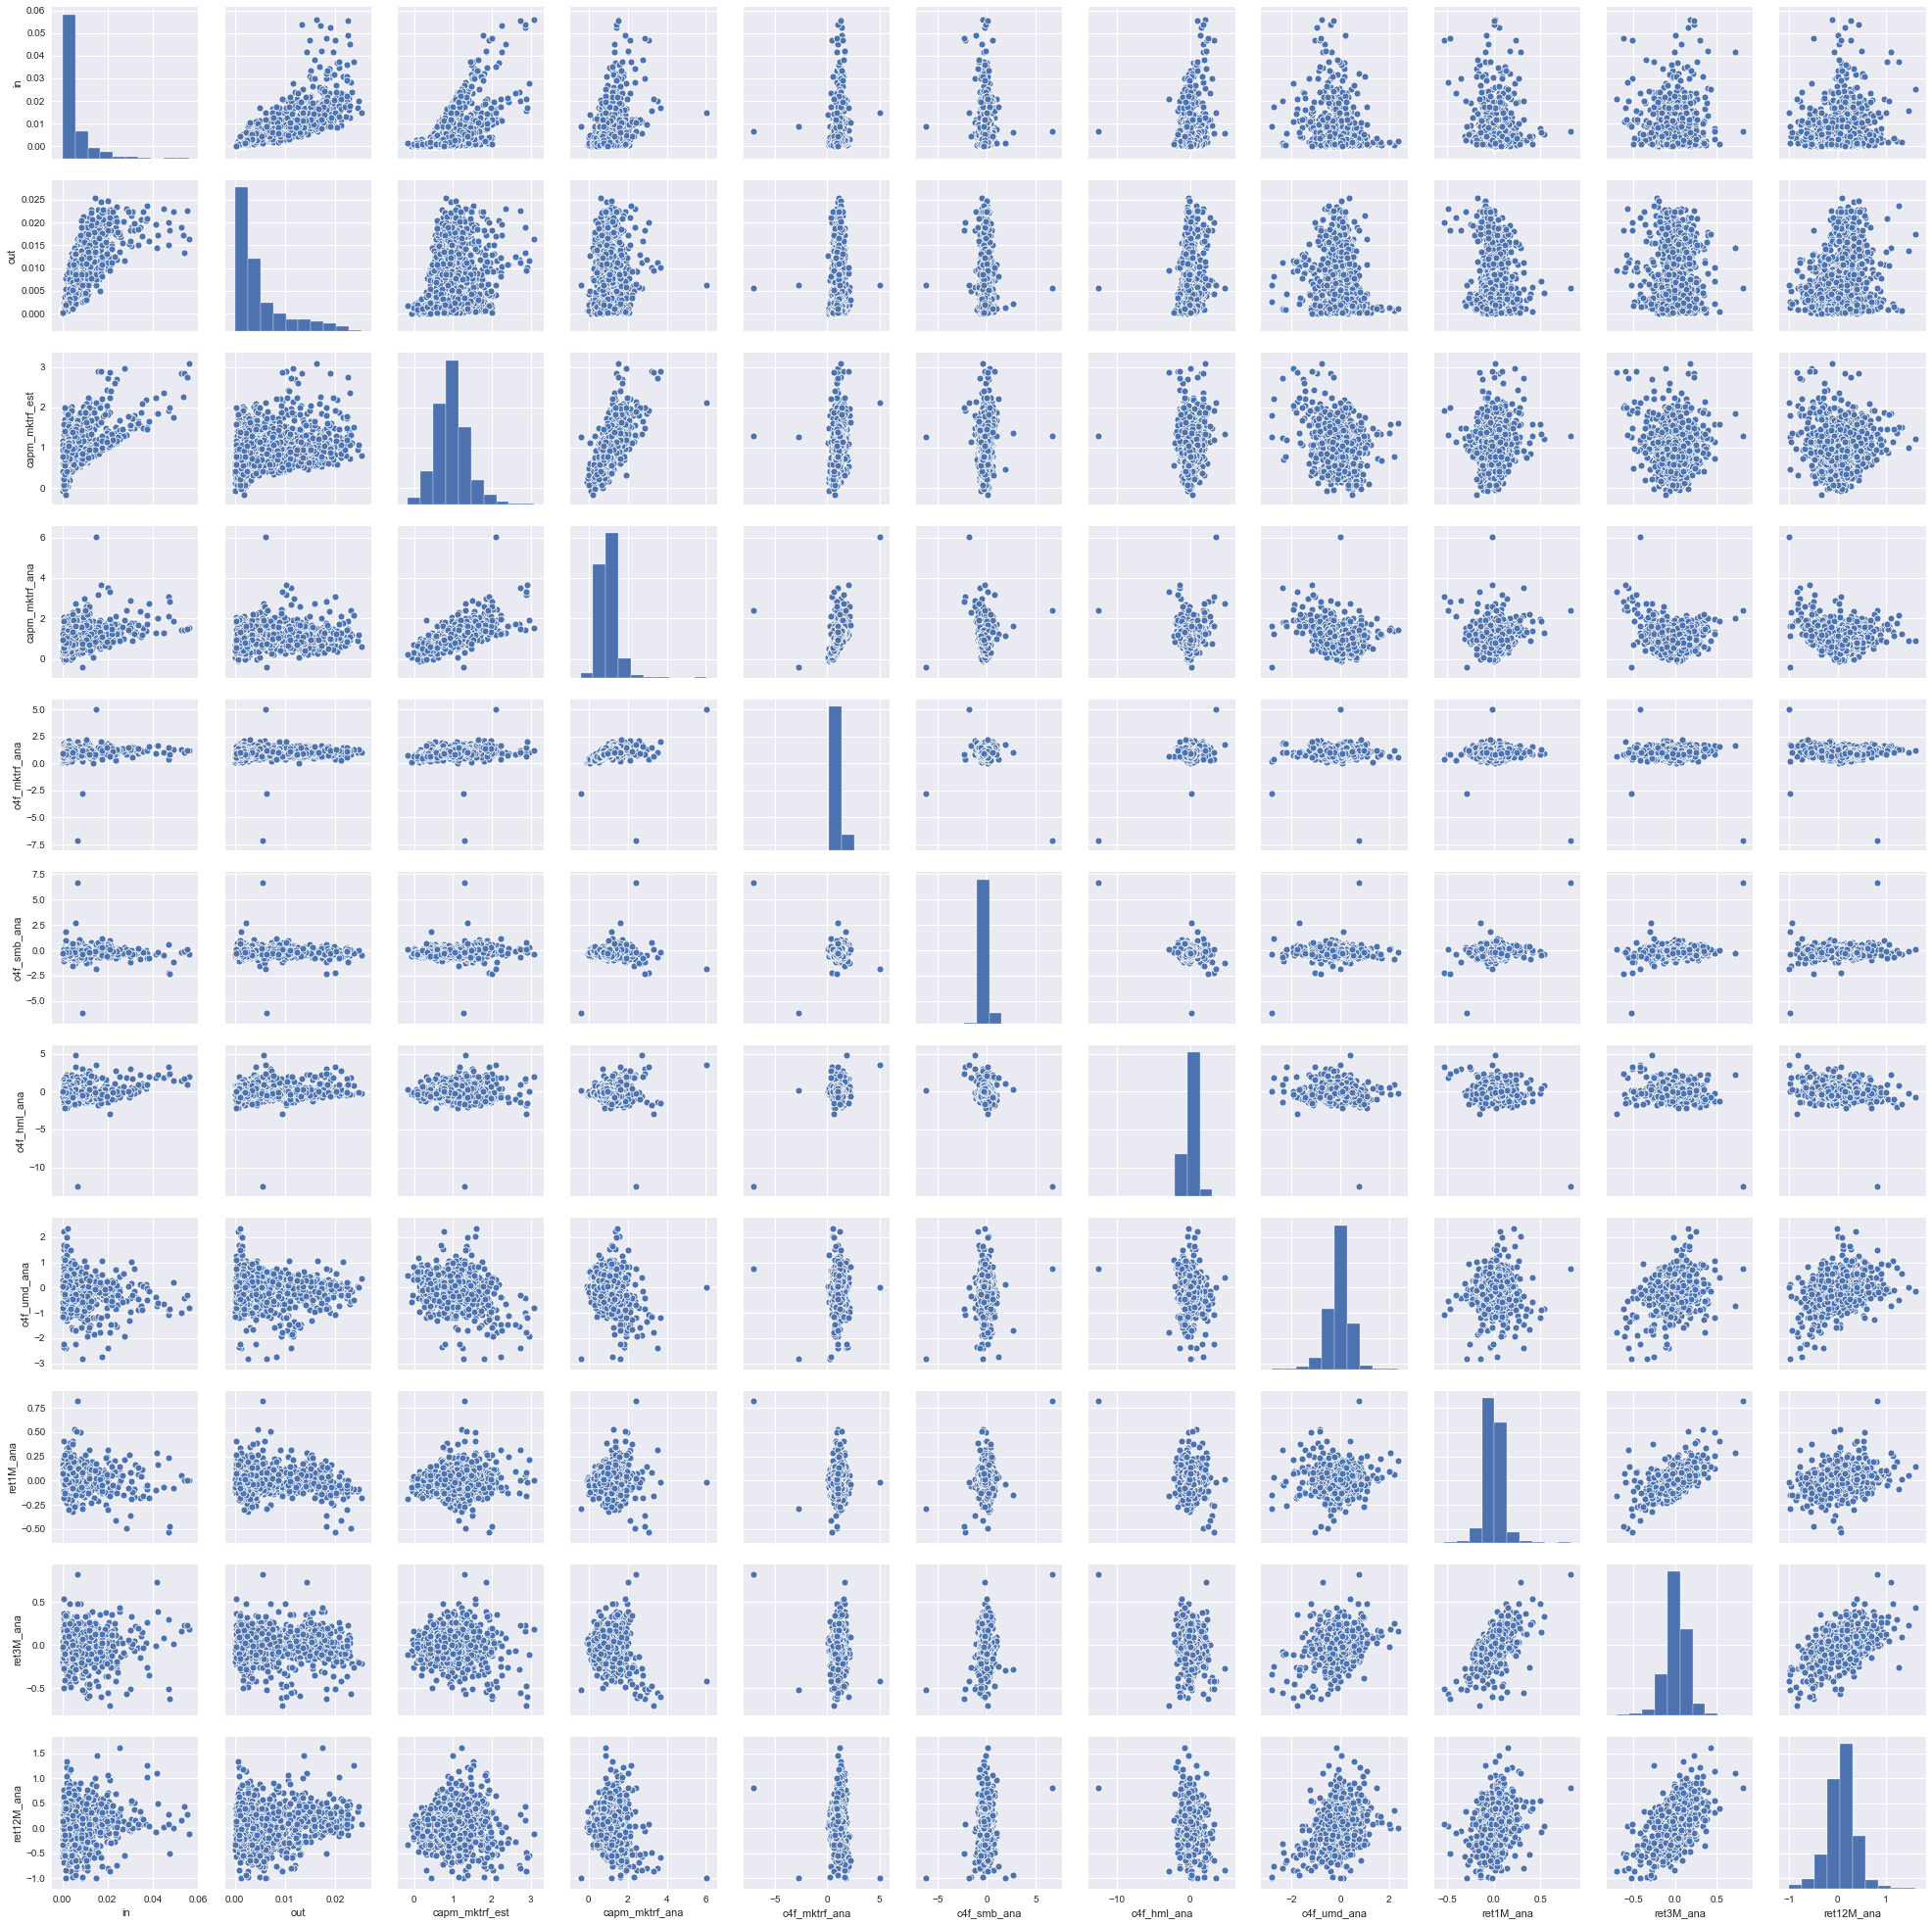

In [14]:
sns.pairplot(df_merged.loc[:,['in','out','capm_mktrf_est','capm_mktrf_ana','c4f_mktrf_ana','c4f_smb_ana','c4f_hml_ana','c4f_umd_ana','ret1M_ana','ret3M_ana','ret12M_ana']])
plt.show()

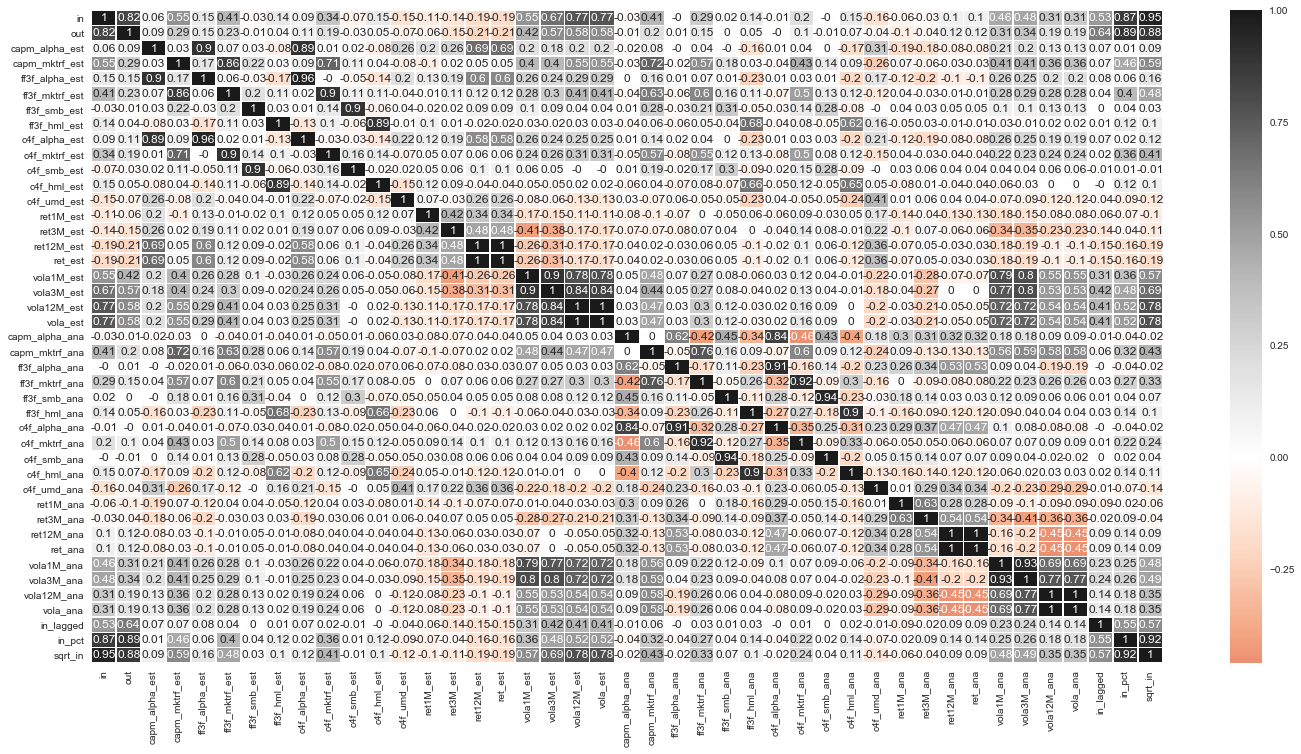

In [15]:
_ = df_merged.plot_corr(figsize=[24,12])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


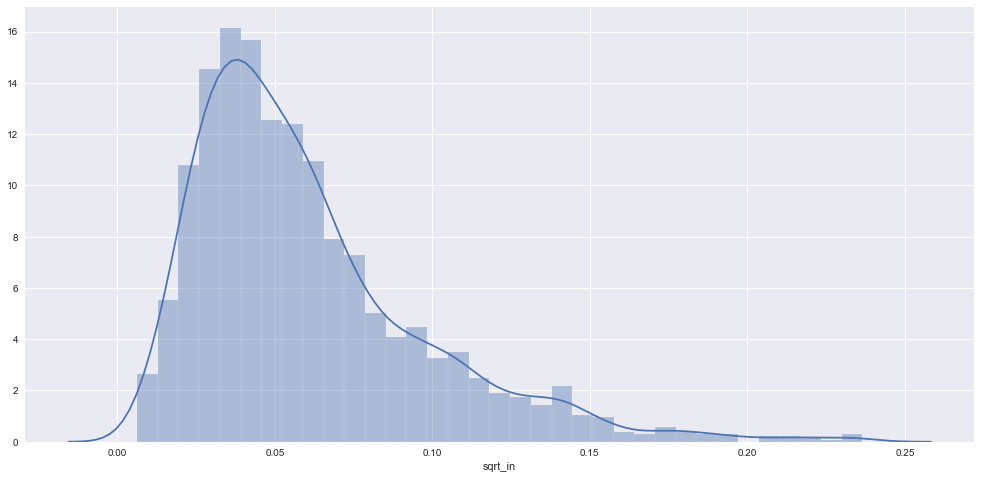

In [16]:
sns.distplot(df_merged['sqrt_in'])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


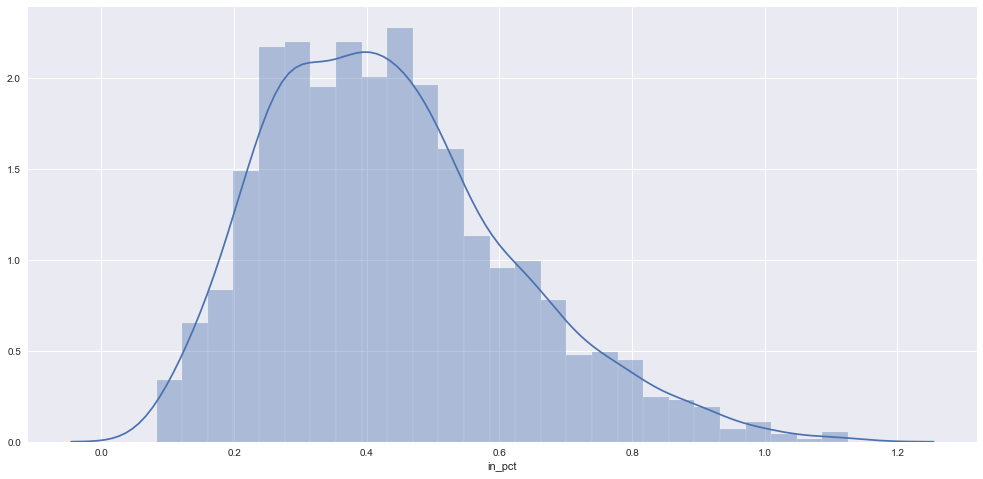

In [17]:
sns.distplot(np.sqrt(df_merged['in_pct']))
plt.show()

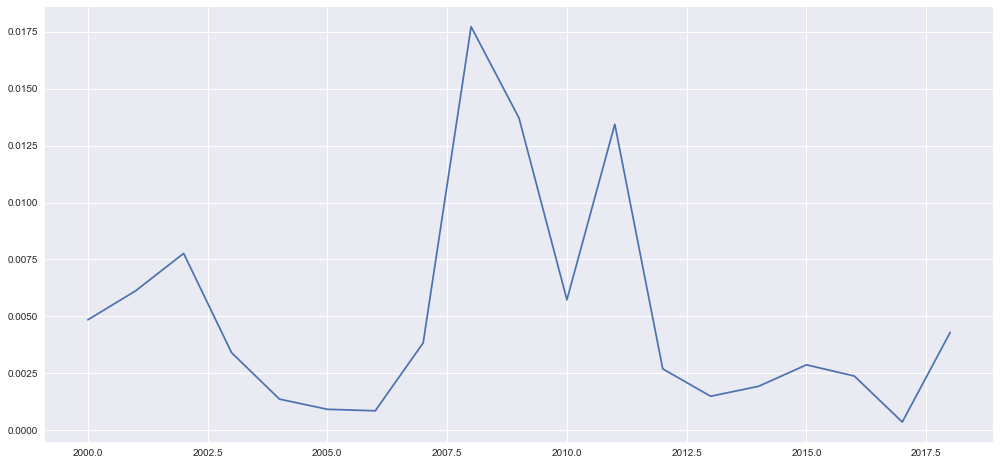

In [18]:
df_merged['in'].groupby(df_merged.index.get_level_values(1)).mean().plot()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


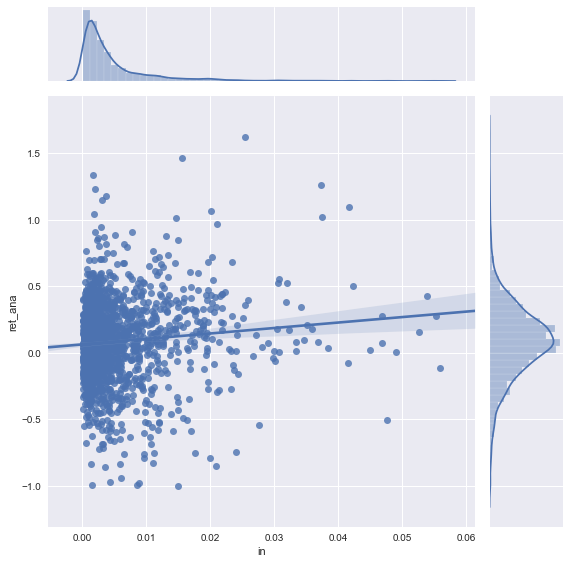

In [19]:
sns.jointplot(x='in', y='ret_ana', data=df_merged, kind='reg', height=8)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


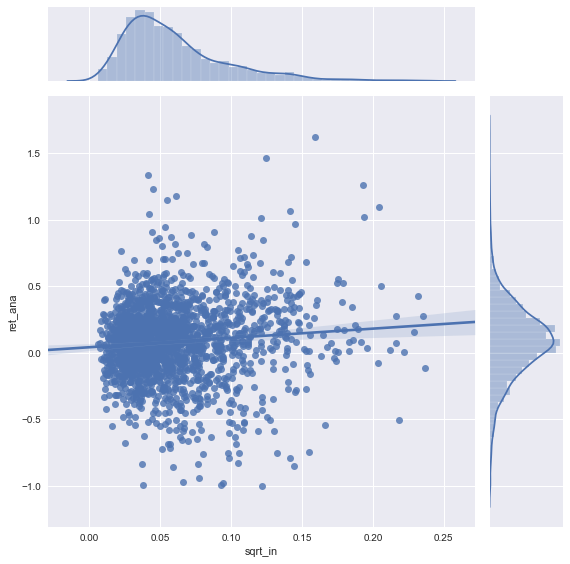

In [20]:
sns.jointplot(x=df_merged['sqrt_in'], y=df_merged['ret_ana'], kind='reg', height=8)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


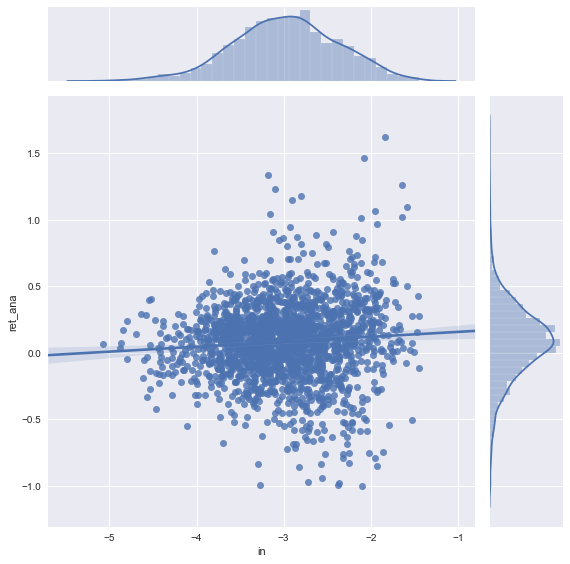

In [23]:
sns.jointplot(x=np.log(np.sqrt(df_merged['in'])), y=df_merged['ret_ana'], kind='reg', height=8)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


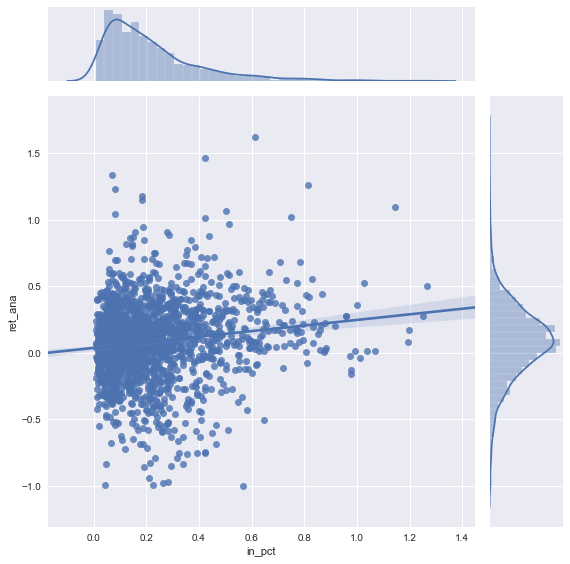

In [41]:
sns.jointplot(x=df_merged['in_pct'], y=df_merged['ret_ana'], kind='reg', height=8)
plt.show()

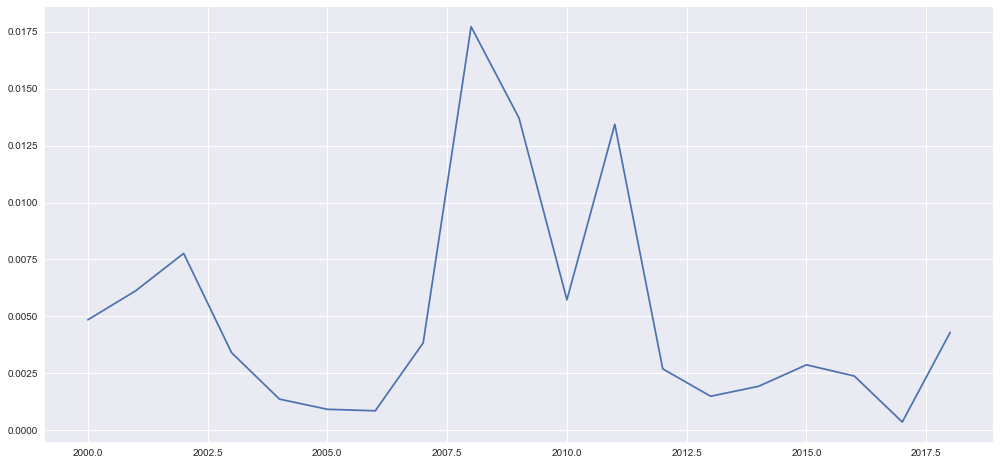

In [46]:
df_merged['in'].groupby(df_merged.index.get_level_values(1)).mean().plot()
plt.show()

## Regressions

In [23]:
def get_var_order(exogs):
    vars_long = []
    vars_short = ['const']
    for reg in exogs:
        if type(reg) is str:
            vars_long += [reg]
        else:
            vars_long += reg
    for var in vars_long:
        if var not in vars_short:
            vars_short += [var]
    return vars_short

In [28]:
exogs = ['in',
        # 'in_pct',
         #'out',
         ['in','capm_mktrf_est','ret_est'],
         ['in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['ff3f_mktrf_est','ff3f_smb_est','ff3f_hml_est'],
         #['c4f_mktrf_est','c4f_smb_est','c4f_hml_est','c4f_umd_est']
         ]
effects = [[],
           ['time'],
           ['entity'],
           ['time', 'entity']]

add_outputs = ['Time FE', 'Entity FE', 'N', 'R-squared', 'R-squared (inclusive)']

var_order = get_var_order(exogs)#['const','in','capm_mktrf_ana','ff3f_mktrf_ana','ff3f_smb_ana','ff3f_hml_ana','c4f_mktrf_ana','c4f_smb_ana','c4f_hml_ana','c4f_umd_ana']

In [34]:
table_panel_regressions = kf.RegressionTable()
endog = 'ret12M_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
                                        .join_regression(df_merged.fit_panel_regression\
                                        (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0, cov_type='kernel'),\
                                        add_outputs=add_outputs)
table_panel_regressions\
    .change_descriptive_order(add_outputs)\
    .change_variable_order(var_order)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)        (2)        (3)       (4)  \
const                 coeff    0.0628*                                   
                      t-stat  (1.7337)                                   
in                    coeff    4.1096*    -0.0541  6.9637***    3.0241   
                      t-stat  (1.8925)  (-0.0247)   (3.3070)  (1.3906)   
capm_mktrf_est        coeff                                              
                      t-stat                                             
ret_est               coeff                                              
                      t-stat                                             
Time FE                          False       True      False      True   
Entity FE                        False      False       True      True   
N                                 1896       1896       1896      1896   
R-squared                       0.0093     0.0000     0.0260    0.0034   
R-squared (inclusive)           0.0093     0.3761     0.1997    0.4982   

                                    (5)        (6)        (7)         (8)  \
const                 coeff   0.1324***                                     
                      t-stat   (5.1691)                                     
in                    coeff   7.0372***  5.4021***  7.7572***   7.7835***   
                      t-stat   (2.6275)   (2.8006)   (3.1171)    (3.7026)   
capm_mktrf_est        coeff    -0.0872*  -0.0858**    -0.0658  -0.1155***   
                      t-stat  (-1.7734)  (-2.3775)  (-1.3666)   (-2.7110)   
ret_est               coeff      0.0038     0.0130    -0.0443     -0.0239   
                      t-stat   (0.1018)   (0.3795)  (-1.2067)   (-0.8195)   
Time FE                           False       True      False        True   
Entity FE                         False      False       True        True   
N                                  1896       1896       1896        1896   
R-squared                        0.0202     0.0103     0.0324      0.0162   
R-squared (inclusive)            0.0202     0.3825     0.2050      0.5047   

                                    (9)       (10)       (11)        (12)  
const                 coeff   0.1326***                                    
                      t-stat   (5.3102)                                    
in                    coeff    6.9799**  5.2683***  8.4059***   7.9740***  
                      t-stat   (2.3132)   (2.6412)   (2.9855)    (3.8885)  
capm_mktrf_est        coeff    -0.0865*  -0.0843**    -0.0714  -0.1166***  
                      t-stat  (-1.6550)  (-2.1350)  (-1.4087)   (-2.8107)  
ret_est               coeff                                                
                      t-stat                                               
Time FE                           False       True      False        True  
Entity FE                         False      False       True        True  
N                                  1896       1896       1896        1896  
R-squared                        0.0201     0.0101     0.0299      0.0153  
R-squared (inclusive)            0.0201     0.3823     0.2030      0.5042

In [35]:
exogs = ['in_pct',
        # 'in_pct',
         #'out',
         ['in_pct','capm_mktrf_est','ret_est'],
         ['in_pct','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['ff3f_mktrf_est','ff3f_smb_est','ff3f_hml_est'],
         #['c4f_mktrf_est','c4f_smb_est','c4f_hml_est','c4f_umd_est']
         ]
effects = [[],
           ['time'],
           ['entity'],
           ['time', 'entity']]

add_outputs = ['Time FE', 'Entity FE', 'N', 'R-squared', 'R-squared (inclusive)']

var_order = get_var_order(exogs)#['const','in','capm_mktrf_ana','ff3f_mktrf_ana','ff3f_smb_ana','ff3f_hml_ana','c4f_mktrf_ana','c4f_smb_ana','c4f_hml_ana','c4f_umd_ana']

In [39]:
table_panel_regressions = kf.RegressionTable()
endog = 'ret12M_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
                                        .join_regression(df_merged.fit_panel_regression\
                                        (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0, cov_type='kernel'),\
                                        add_outputs=add_outputs)
table_panel_regressions\
    .change_descriptive_order(add_outputs)\
    .change_variable_order(var_order)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)       (2)        (3)       (4)  \
const                 coeff      0.0364                                  
                      t-stat   (0.8644)                                  
in_pct                coeff   0.2103***    0.0085  0.2691***    0.1321   
                      t-stat   (2.8859)  (0.1096)   (2.7495)  (1.2611)   
capm_mktrf_est        coeff                                              
                      t-stat                                             
ret_est               coeff                                              
                      t-stat                                             
Time FE                           False      True      False      True   
Entity FE                         False     False       True      True   
N                                  1896      1896       1896      1896   
R-squared                        0.0193    0.0000     0.0307    0.0028   
R-squared (inclusive)            0.0193    0.3761     0.2035    0.4979   

                                    (5)        (6)        (7)         (8)  \
const                 coeff   0.1011***                                     
                      t-stat   (4.6141)                                     
in_pct                coeff   0.2971***   0.2500**   0.2784**   0.3420***   
                      t-stat   (2.7068)   (2.4386)   (2.4727)    (5.0434)   
capm_mktrf_est        coeff   -0.0868**  -0.0884**    -0.0486  -0.1069***   
                      t-stat  (-2.2550)  (-2.2721)  (-1.1205)   (-2.9326)   
ret_est               coeff      0.0034     0.0103    -0.0483     -0.0314   
                      t-stat   (0.0795)   (0.2935)  (-1.2608)   (-1.0374)   
Time FE                           False       True      False        True   
Entity FE                         False      False       True        True   
N                                  1896       1896       1896        1896   
R-squared                        0.0315     0.0113     0.0359      0.0146   
R-squared (inclusive)            0.0315     0.3831     0.2079      0.5039   

                                    (9)       (10)       (11)        (12)  
const                 coeff   0.1015***                                    
                      t-stat   (4.6603)                                    
in_pct                coeff    0.2958**   0.2475**   0.2984**   0.3432***  
                      t-stat   (2.5727)   (2.2691)   (2.4079)    (5.3530)  
capm_mktrf_est        coeff   -0.0864**  -0.0876**    -0.0518  -0.1061***  
                      t-stat  (-2.1189)  (-2.0960)  (-1.1973)   (-3.1808)  
ret_est               coeff                                                
                      t-stat                                               
Time FE                           False       True      False        True  
Entity FE                         False      False       True        True  
N                                  1896       1896       1896        1896  
R-squared                        0.0315     0.0111     0.0330      0.0130  
R-squared (inclusive)            0.0315     0.3830     0.2054      0.5031

In [57]:
exogs = ['sqrt_in',
        # 'in_pct',
         #'out',
         ['sqrt_in','capm_mktrf_est','ret_est'],
         ['sqrt_in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['ff3f_mktrf_est','ff3f_smb_est','ff3f_hml_est'],
         #['c4f_mktrf_est','c4f_smb_est','c4f_hml_est','c4f_umd_est']
         ]
effects = [[],
           ['time'],
           ['entity'],
           ['time', 'entity']]

add_outputs = ['Time FE', 'Entity FE', 'N', 'R-squared', 'R-squared (inclusive)']

var_order = get_var_order(exogs)#['const','in','capm_mktrf_ana','ff3f_mktrf_ana','ff3f_smb_ana','ff3f_hml_ana','c4f_mktrf_ana','c4f_smb_ana','c4f_hml_ana','c4f_umd_ana']

In [58]:
table_panel_regressions = kf.RegressionTable()
endog = 'ret12M_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
                                        .join_regression(df_merged.fit_panel_regression\
                                        (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0, cov_type='kernel'),\
                                        add_outputs=add_outputs)
table_panel_regressions\
    .change_descriptive_order(add_outputs)\
    .change_variable_order(var_order)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)        (2)       (3)       (4)  \
const                 coeff     0.0411                                  
                      t-stat  (1.0268)                                  
sqrt_in               coeff     0.7004    -0.2048  1.2650**    0.3862   
                      t-stat  (1.4615)  (-0.4000)  (2.5542)  (0.5962)   
capm_mktrf_est        coeff                                             
                      t-stat                                            
ret_est               coeff                                             
                      t-stat                                            
Time FE                          False       True     False      True   
Entity FE                        False      False      True      True   
N                                 1896       1896      1896      1896   
R-squared                       0.0081     0.0004    0.0246    0.0010   
R-squared (inclusive)           0.0081     0.3763    0.1986    0.4970   

                                    (5)         (6)        (7)         (8)  \
const                 coeff   0.0938***                                      
                      t-stat   (4.1916)                                      
sqrt_in               coeff    1.3059**   2.0159***   1.4076**   2.6198***   
                      t-stat   (2.3906)    (2.6721)   (2.4152)    (4.0097)   
capm_mktrf_est        coeff   -0.0923**  -0.1413***    -0.0643  -0.1759***   
                      t-stat  (-2.1936)   (-2.6451)  (-1.3532)   (-3.5160)   
ret_est               coeff      0.0037      0.0110    -0.0444     -0.0283   
                      t-stat   (0.0996)    (0.3091)  (-1.3160)   (-0.9493)   
Time FE                           False        True      False        True   
Entity FE                         False       False       True        True   
N                                  1896        1896       1896        1896   
R-squared                        0.0195      0.0128     0.0308      0.0176   
R-squared (inclusive)            0.0195      0.3840     0.2037      0.5053   

                                    (9)       (10)       (11)        (12)  
const                 coeff   0.0942***                                    
                      t-stat   (4.1418)                                    
sqrt_in               coeff    1.2952**   1.9953**   1.5330**   2.6516***  
                      t-stat   (2.1271)   (2.5372)   (2.3879)    (4.1375)  
capm_mktrf_est        coeff   -0.0916**  -0.1400**    -0.0702  -0.1767***  
                      t-stat  (-1.9652)  (-2.4379)  (-1.4023)   (-3.6916)  
ret_est               coeff                                                
                      t-stat                                               
Time FE                           False       True      False        True  
Entity FE                         False      False       True        True  
N                                  1896       1896       1896        1896  
R-squared                        0.0195     0.0126     0.0284      0.0163  
R-squared (inclusive)            0.0195     0.3839     0.2017      0.5047

In [61]:
table_panel_regressions = kf.RegressionTable()
endog = 'var12M_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
                                        .join_regression(df_merged.fit_panel_regression\
                                        (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0),\
                                        add_outputs=add_outputs)
table_panel_regressions\
    .change_variable_order(var_order)\
    .change_descriptive_order(add_outputs)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)        (2)       (3)       (4)  \
const                 coeff      0.0000                                  
                      t-stat   (0.4543)                                  
sqrt_in               coeff   0.0072***  0.0126***  0.0051**  0.0097**   
                      t-stat   (2.6177)   (2.6882)  (2.3668)  (2.2673)   
capm_mktrf_est        coeff                                              
                      t-stat                                             
ret_est               coeff                                              
                      t-stat                                             
Time FE                           False       True     False      True   
Entity FE                         False      False      True      True   
N                                  1896       1896      1896      1896   
R-squared                        0.0365     0.0520    0.0274    0.0311   
R-squared (inclusive)            0.0365     0.1890    0.5054    0.5997   

                                     (5)        (6)        (7)        (8)  \
const                 coeff     -0.0002*                                    
                      t-stat   (-1.8204)                                    
sqrt_in               coeff       0.0027     0.0002    0.0032*     0.0056   
                      t-stat    (1.1129)   (0.0347)   (1.7431)   (1.1572)   
capm_mktrf_est        coeff     0.0006**   0.0008**    0.0004*     0.0003   
                      t-stat    (2.2648)   (1.9911)   (1.8563)   (1.3723)   
ret_est               coeff   -0.0003***    -0.0002    -0.0002    -0.0001   
                      t-stat   (-2.6908)  (-1.5155)  (-1.3497)  (-0.7409)   
Time FE                            False       True      False       True   
Entity FE                          False      False       True       True   
N                                   1896       1896       1896       1896   
R-squared                         0.0594     0.0652     0.0372     0.0352   
R-squared (inclusive)             0.0594     0.2002     0.5104     0.6014   

                                    (9)      (10)      (11)      (12)  
const                 coeff   -0.0003**                                
                      t-stat  (-2.0472)                                
sqrt_in               coeff      0.0036    0.0006   0.0038*    0.0058  
                      t-stat   (1.4431)  (0.0888)  (1.9269)  (1.1731)  
capm_mktrf_est        coeff    0.0006**   0.0008*   0.0003*    0.0003  
                      t-stat   (2.1477)  (1.8204)  (1.8684)  (1.3263)  
ret_est               coeff                                            
                      t-stat                                           
Time FE                           False      True     False      True  
Entity FE                         False     False      True      True  
N                                  1896      1896      1896      1896  
R-squared                        0.0543    0.0632    0.0335    0.0335  
R-squared (inclusive)            0.0543    0.1985    0.5086    0.6007

In [55]:
exogs = ['in',
         'capm_mktrf_est',
         ['in','out','capm_mktrf_est']]
effects = [[],
           ['time'],
           ['entity'],
           ['time', 'entity']]

add_outputs = ['Time FE', 'Entity FE', 'N', 'R-squared', 'R-squared (inclusive)']

var_order = ['const','in','out','capm_mktrf_est','capm_mktrf_ana']

In [54]:
table_panel_regressions = kf.RegressionTable()
endog = 'capm_mktrf_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
            .join_regression(df_merged.fit_panel_regression\
            (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0),\
            add_outputs=add_outputs)
table_panel_regressions\
    .change_variable_order(var_order)\
    .change_descriptive_order(add_outputs)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)         (2)         (3)         (4)  \
const                 coeff    0.8565***                                       
                      t-stat   (34.9934)                                       
in                    coeff   26.0591***  50.3926***  11.7218***  23.7032***   
                      t-stat    (4.0196)    (4.3435)    (3.7796)    (3.6460)   
capm_mktrf_est        coeff                                                    
                      t-stat                                                   
ret_est               coeff                                                    
                      t-stat                                                   
capm_alpha_est        coeff                                                    
                      t-stat                                                   
Time FE                            False        True       False        True   
Entity FE                          False       False        True        True   
N                                   1896        1896        1896        1896   
R-squared                         0.1676      0.3309      0.0684      0.1224   
R-squared (inclusive)             0.1676      0.3451      0.6325      0.6677   

                                    (5)        (6)        (7)        (8)  \
const                 coeff   0.2552***                                    
                      t-stat   (5.1427)                                    
in                    coeff      0.9925     3.8695     3.7642     9.0410   
                      t-stat   (0.2672)   (0.4844)   (1.0249)   (1.1187)   
capm_mktrf_est        coeff   0.7497***  0.7372***  0.3758***  0.3438***   
                      t-stat  (10.8979)   (8.0848)   (5.6093)   (3.1886)   
ret_est               coeff     -0.0202     0.0153    -0.0299    -0.0117   
                      t-stat  (-0.3238)   (0.2155)  (-0.4017)  (-0.1378)   
capm_alpha_est        coeff                                                
                      t-stat                                               
Time FE                           False       True      False       True   
Entity FE                         False      False       True       True   
N                                  1896       1896       1896       1896   
R-squared                        0.5261     0.5513     0.1691     0.1839   
R-squared (inclusive)            0.5261     0.5608     0.6722     0.6910   

                                     (9)        (10)        (11)        (12)  
const                 coeff    0.8327***                                      
                      t-stat   (39.8087)                                      
in                    coeff   27.5580***  50.5643***  11.1669***  23.2220***  
                      t-stat    (4.0695)    (4.3259)    (3.0623)    (3.5369)  
capm_mktrf_est        coeff                                                   
                      t-stat                                                  
ret_est               coeff       0.1510      0.0600     -0.0358     -0.0963  
                      t-stat    (0.7745)    (0.1589)   (-0.3622)   (-0.4971)  
capm_alpha_est        coeff     -12.6873     10.5228     16.9875     32.9013  
                      t-stat   (-0.2405)    (0.1062)    (0.9269)    (0.7222)  
Time FE                            False        True       False        True  
Entity FE                          False       False        True        True  
N                                   1896        1896        1896        1896  
R-squared                         0.1771      0.3348      0.0698      0.1244  
R-squared (inclusive)             0.1771      0.3488      0.6331      0.6684

In [61]:
table_panel_regressions = kf.RegressionTable()
endog = 'ff3f_hml_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
            .join_regression(df_merged.fit_panel_regression\
            (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0),\
            add_outputs=add_outputs)
table_panel_regressions\
    .change_variable_order(var_order)\
    .change_descriptive_order(add_outputs)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)       (2)       (3)         (4)  \
const                 coeff     -0.0839                                   
                      t-stat  (-1.6078)                                   
in                    coeff    16.1447*  30.0461*  8.7107**  18.0793***   
                      t-stat   (1.8877)  (1.6656)  (2.3122)    (4.0384)   
out                   coeff                                               
                      t-stat                                              
capm_mktrf_est        coeff                                               
                      t-stat                                              
capm_mktrf_ana        coeff         NaN       NaN       NaN         NaN   
                      t-stat        NaN       NaN       NaN         NaN   
Time FE                           False      True     False        True   
Entity FE                         False     False      True        True   
N                                  1896      1896      1896        1896   
R-squared                        0.0194    0.0354    0.0110      0.0215   
R-squared (inclusive)            0.0194    0.0501    0.5966      0.6295   

                                    (5)       (6)        (7)       (8)  \
const                 coeff     -0.0649                                  
                      t-stat  (-0.2272)                                  
in                    coeff                                              
                      t-stat                                             
out                   coeff                                              
                      t-stat                                             
capm_mktrf_est        coeff      0.0638    0.0649    -0.0099    0.0225   
                      t-stat   (0.2086)  (0.2052)  (-0.0734)  (0.1578)   
capm_mktrf_ana        coeff         NaN       NaN        NaN       NaN   
                      t-stat        NaN       NaN        NaN       NaN   
Time FE                           False      True      False      True   
Entity FE                         False     False       True      True   
N                                  1896      1896       1896      1896   
R-squared                        0.0011    0.0012     0.0000    0.0001   
R-squared (inclusive)            0.0011    0.0164     0.5921    0.6214   

                                      (9)        (10)         (11)        (12)  
const                 coeff        0.1756                                       
                      t-stat     (0.6922)                                       
in                    coeff    49.7146***  58.5444***   42.0031***  39.0440***  
                      t-stat     (4.1225)    (3.9991)     (3.8624)    (3.8222)  
out                   coeff   -39.8051***      4.4887  -40.6025***  -57.4574**  
                      t-stat    (-3.0949)    (0.3907)    (-3.2476)   (-2.4960)  
capm_mktrf_est        coeff       -0.2336     -0.4732     -0.2671*     -0.1476  
                      t-stat    (-0.8238)   (-1.3871)    (-1.8701)   (-0.8335)  
capm_mktrf_ana        coeff           NaN         NaN          NaN         NaN  
                      t-stat          NaN         NaN          NaN         NaN  
Time FE                             False        True        False        True  
Entity FE                           False       False         True        True  
N                                    1896        1896         1896        1896  
R-squared                          0.0429      0.0616       0.0606      0.0678  
R-squared (inclusive)              0.0429      0.0759       0.6168      0.6470